# Reading the Data

In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.linear_model import LinearRegression
import pywt

import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# #Transforming the data format into 5S-interval
def transform_data(df, dates, interval="1S"):
    df = df.groupby([df.index, "Type"]).mean().reset_index()
    df = df.pivot(index="Dates", columns="Type", values="Price")

    bid_df = df["BEST_BID"]
    ask_df = df["BEST_ASK"]
    trade_df = df["TRADE"]

    result_dfs = []
    for date in dates:
        start_time = datetime.datetime.combine(
            date, datetime.datetime.min.time()
        ) + datetime.timedelta(hours=9)
        end_time = datetime.datetime.combine(
            date, datetime.datetime.min.time()
        ) + datetime.timedelta(hours=16, minutes=1)

        bid_df_day = bid_df.loc[start_time:end_time].resample(interval).last().ffill()
        ask_df_day = ask_df.loc[start_time:end_time].resample(interval).last().ffill()
        trade_df_day = (
            trade_df.loc[start_time:end_time].resample(interval).last().ffill()
        )

        result_df = pd.concat([bid_df_day, ask_df_day, trade_df_day], axis=1)
        result_df.columns = ["BID", "ASK", "TRADE"]

        result_df["MID"] = (result_df["BID"] + result_df["ASK"]) / 2
        result_df = result_df[["BID", "MID", "ASK", "TRADE"]]

        result_dfs.append(result_df)

    final_df = pd.concat(result_dfs)

    return final_df


# Define a function to replace values with NaN during a specific time interval
def replace_with_nan(df):
    mask = (df.index.time > datetime.time(12, 0)) & (
        df.index.time < datetime.time(14, 0)
    )
    df.loc[mask] = np.nan
    return df


def calculate_returns(df):
    # Calculate the percentage change (returns)
    df_returns = df.pct_change()

    # Drop any NA values generated by the pct_change function
    df_returns = df_returns.dropna()

    return df_returns


def align_dataframes(*dfs):
    # Find the intersection of all indices
    common_index = dfs[0].index
    for df in dfs[1:]:
        common_index = common_index.intersection(df.index)

    # Reindex all dataframes with the common index
    return [df.reindex(common_index) for df in dfs]

def wavelet_denoise(data, wavelet, level):
    # Remember the original data length
    original_length = len(data)

    # Ensure the data length is even
    if len(data) % 2:
        data = np.pad(data, (0, 1), 'edge')

    # Decompose to get wavelet coefficients
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)

    # Calculate sigma for threshold as defined in
    # Donoho and Johnstone 1994, p. 12
    sigma = (1/0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level])))

    # Calculate universal threshold
    uthresh = sigma * np.sqrt(2*np.log(len(data)))
    coeff = list(map(lambda x: pywt.threshold(x, value=uthresh, mode="soft"), coeff))

    # Reconstruct the signal using the thresholded coefficients
    denoised_data = pywt.waverec(coeff, wavelet, mode="per")

    # Truncate back to the original length if necessary
    if original_length != len(denoised_data):
        denoised_data = denoised_data[:original_length]

    return denoised_data

def colorize(row):
    if (row["New Accuracy"] == Acc_table.min().min()):
        return ['color: green', 'color: black']
    elif  (row["Previous Accuracy"] == Acc_table.min().min()): 
        return ['color: black', 'color: green']
    elif row["New Accuracy"] < row["Previous Accuracy"]:
        return ['color: blue', 'color: black']
    else:
        return ['color: black', 'color: blue']
    
def get_pred_path(date, time, model, window):
    y_pred = model.predict(df[(df.index.date == date) & (df.index.time <= time)][["CMPN"]]) # Fit 

    y_pred = pd.DataFrame(y_pred, index = df[(df.index.date == date) & (df.index.time <= time)].index, columns = ["Prediction"])
    y_pred = y_pred.ewm(span=window).mean()
    real_closing = df[(df.index.date == date) & (df.index.time == datetime.time(12, 0))]["TPFT"].values[0]
    est_closing = y_pred[(y_pred.index.date == date) & (y_pred.index.time == datetime.time(12, 0))]["Prediction"].values[0]
    y_pred = y_pred - est_closing + real_closing # Shift
    
    return y_pred

In [3]:
path = "./Dataset"
files = [f for f in os.listdir(path) if f.endswith(".txt")]
print(f"Found files in the main folder: {files}")

dic = {}
for file_path in files:
    if file_path == "BNTD_1201_0526.txt":
        df = pd.read_csv("./Dataset/BNTD_1201_0526.txt", sep=",", skiprows=2)
        df["Dates"] = pd.to_datetime(
            df["Dates"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
        )
    else:
        df = pd.read_csv(path + "/" + file_path, sep="\t", skiprows=2)
        df["Dates"] = pd.to_datetime(
            df["Dates"], format="%Y/%m/%d %p %I:%M:%S", errors="coerce"
        )

    df.dropna(subset=["Dates"], inplace=True)

    df.set_index("Dates", inplace=True)
    dic[file_path] = df
    print(file_path + " loaded.")

Found files in the main folder: ['BNTD_1201_0526.txt', 'CMPN_0101_0131.txt', 'CMPN_0201_0228.txt', 'CMPN_0301_0331.txt', 'CMPN_0401_0430.txt', 'CMPN_0501_0526.txt', 'CMPN_1201_1231.txt', 'TPFT_1201_0526.txt']
BNTD_1201_0526.txt loaded.
CMPN_0101_0131.txt loaded.
CMPN_0201_0228.txt loaded.
CMPN_0301_0331.txt loaded.
CMPN_0401_0430.txt loaded.
CMPN_0501_0526.txt loaded.
CMPN_1201_1231.txt loaded.
TPFT_1201_0526.txt loaded.


In [5]:
# Set time interval
time_interval = "1S"

# create empty DataFrames for each category
df_TPFT = pd.DataFrame()
df_CMPN = pd.DataFrame()

# iterate through dictionary keys
for key in dic.keys():
    # determine category
    category = key.split("_")[0]
    # concatenate DataFrame to appropriate category
    if category == "TPFT":
        df_TPFT = pd.concat([df_TPFT, dic[key]])
    elif category == "CMPN":
        df_CMPN = pd.concat([df_CMPN, dic[key]])

# Now df_COFX, df_REGN, df_TPFT, df_CMPN, and df_BGN each contain all the data from the respective category across all dates
df_TPFT = df_TPFT.sort_index()
df_CMPN = df_CMPN.sort_index()
display(f"TPFT Length: {len(df_TPFT)}, CMPN Length: {len(df_CMPN)}")

# Formatting the data type as float
df_TPFT["Price"] = df_TPFT["Price"].astype(float)
df_CMPN["Price"] = df_CMPN["Price"].astype(float)

# Create dates overlapping
unique_TPFT_dates = set(pd.unique(df_TPFT.index.date))
unique_CMPN_dates = set(pd.unique(df_CMPN.index.date))

# Get the unique dates that are only in TPFT and not in the others
unique_to_TPFT = (
    unique_TPFT_dates
    - unique_CMPN_dates
)



# Get the unique dates that are only in CMPN and not in the others
unique_to_CMPN = (
    unique_CMPN_dates
    - unique_TPFT_dates
)


# If you want the dates that are in all dataframes
dates = (
    unique_TPFT_dates
    & unique_CMPN_dates
)

dates = list(dates)
dates.remove(datetime.date(2023, 4, 18))
dates = sorted(dates)

# Now, apply the function to your dataframes
df_TPFT = transform_data(df_TPFT, dates, time_interval)
df_CMPN = transform_data(df_CMPN, dates, time_interval)


# Now df_COFX, df_REGN, df_TPFT, df_CMPN, and df_BGN each contain all the data from the respective category across all dates
df_TPFT = df_TPFT.sort_index()
df_CMPN = df_CMPN.sort_index()

# Drop Nan
df_TPFT = df_TPFT.dropna(subset=["MID"])
df_CMPN = df_CMPN.dropna(subset=["MID"])

# Transform to BP format
df_TPFT_BP = calculate_returns(df_TPFT)
df_CMPN_BP = calculate_returns(df_CMPN)

# Reformatting in same shape
df_TPFT, df_CMPN = align_dataframes(
    df_TPFT, df_CMPN
)
df_TPFT_BP, df_CMPN_BP = align_dataframes(
    df_TPFT_BP, df_CMPN_BP
)
print(df_TPFT.shape, df_CMPN.shape)

# Restore the fact that TPFT is not being traded between 12 and 14 every day
df_TPFT = replace_with_nan(df_TPFT)
df_TPFT_BP = replace_with_nan(df_TPFT_BP)

df_est = pd.DataFrame()
df_est = pd.concat([df_est, dic["BNTD_1201_0526.txt"]])
df_est = df_est.sort_index()
df_est["Price"] = df_est["Price"].astype(float)
df_est = transform_data(df_est, dates, time_interval)
df_est = df_est.sort_index()
df_est = df_est.dropna(subset=["MID"])
df_est_BP = calculate_returns(df_est)

'TPFT Length: 135976, CMPN Length: 5023576'

(2839713, 4) (2839713, 4)


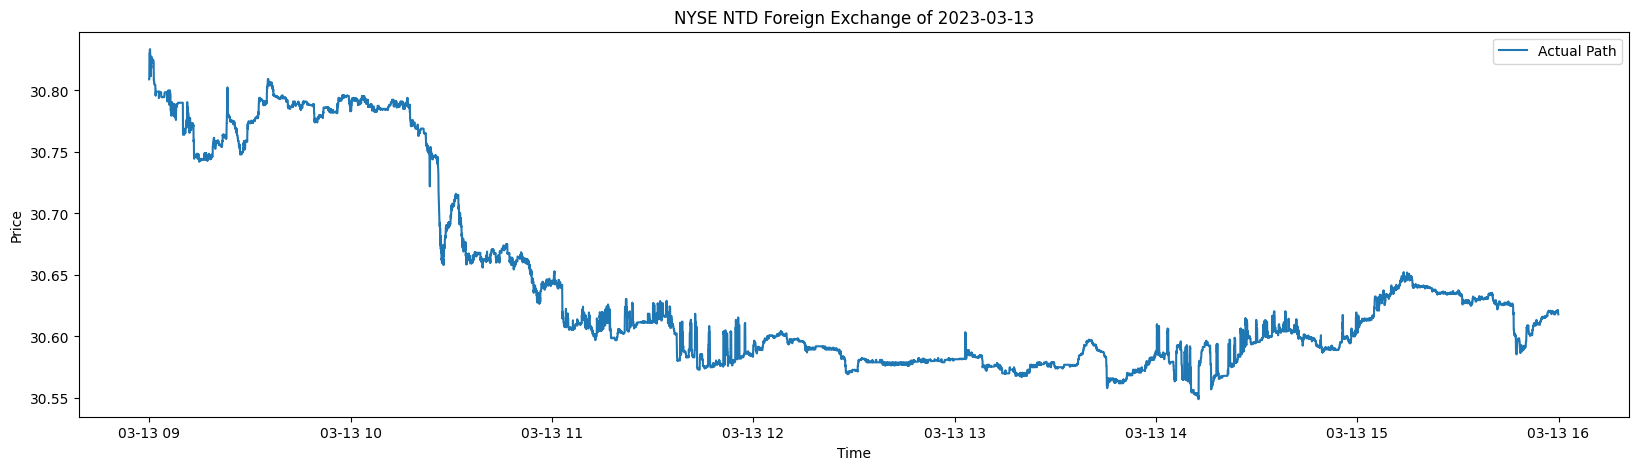

In [6]:
df = df_CMPN['MID'].loc[df_CMPN.index.date == datetime.date(2023, 3, 13)]

plt.figure(figsize = (20, 5))
plt.title(f"NYSE NTD Foreign Exchange of {datetime.date(2023, 3, 13)}")
plt.plot(df, "-", label = "Actual Path")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Real-time Imitation

## Linear Regression + Wavelet Signal Denoiser + Shifting

Processing: 100%|██████████| 18000/18000 [05:19<00:00, 56.40rows/s]


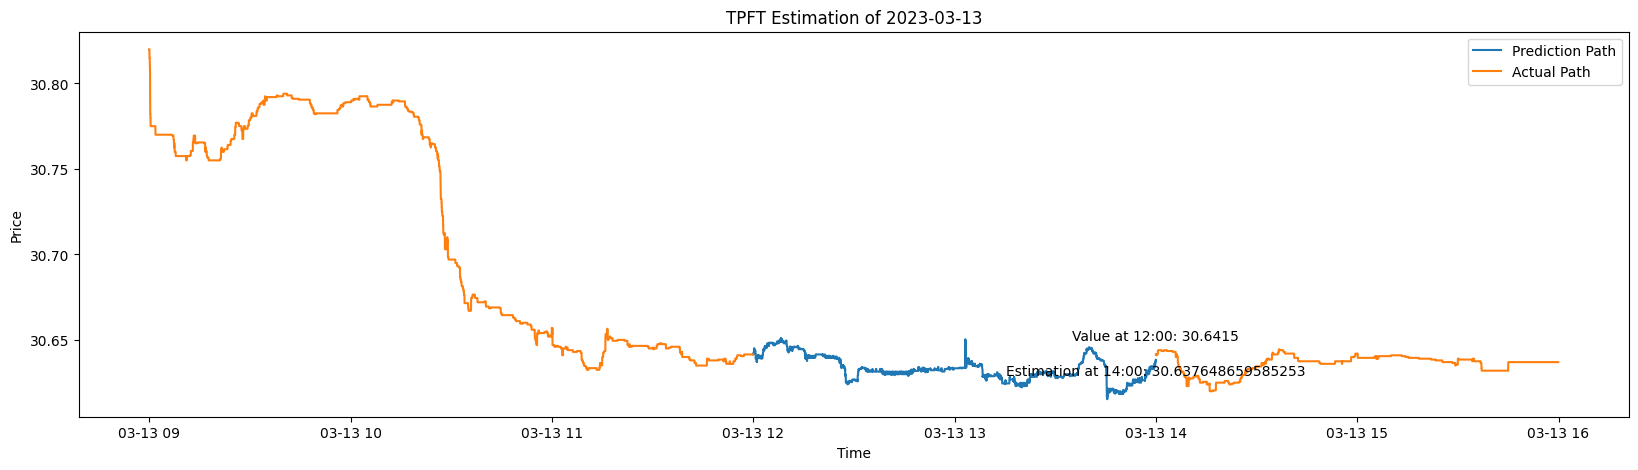

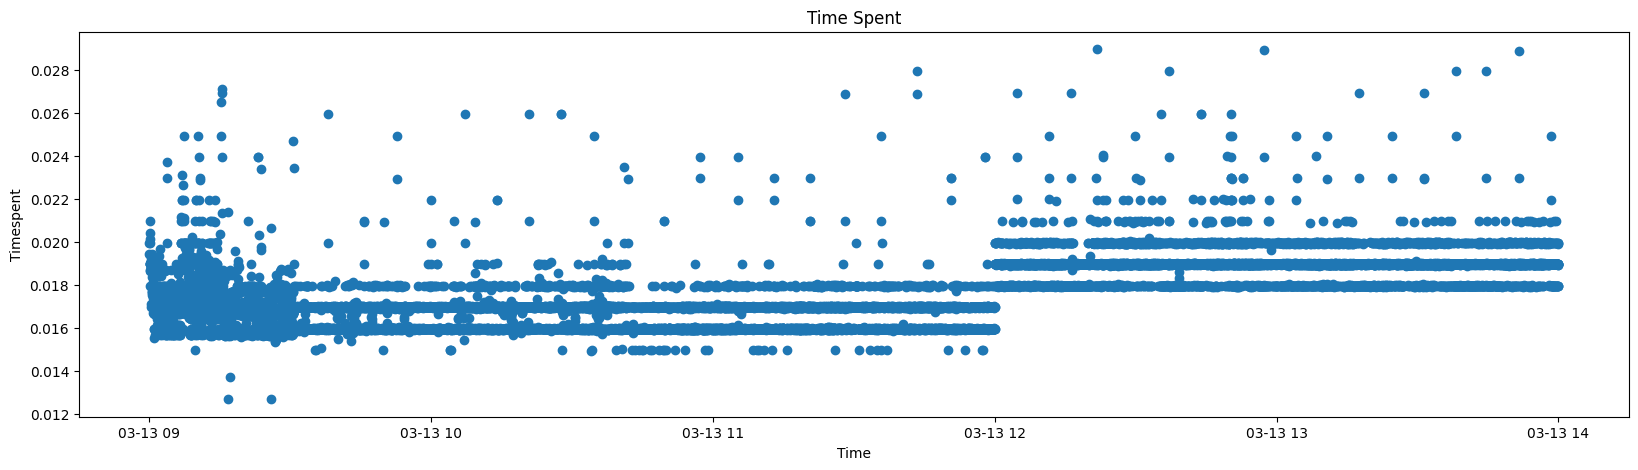

In [23]:
chosen_date = datetime.date(2023, 3, 13)
X_record = np.array([])
y_record = np.array([])
model = LinearRegression()
time_record = []

df = pd.DataFrame({"TPFT": df_TPFT["MID"],  
                "CMPN": df_CMPN["MID"]})

for date_idx in tqdm(df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(14, 0))].index, desc="Processing", unit="rows"):
    start = time.time()
    
    TPFT_new_input = df[df.index == date_idx]["TPFT"].values[0]
    CMPN_new_input = df[df.index == date_idx]["CMPN"].values[0]
    X_record = np.append(X_record, [CMPN_new_input])
    
    if date_idx.time() <= datetime.time(12, 0): # Storing all training sets 
        y_record = np.append(y_record, [TPFT_new_input])
        
    if date_idx.time() == datetime.time(12, 0): # Fit and get Parameters ONLY ONCE! 
        real_closing = TPFT_new_input
        X_record = X_record.reshape(-1, 1)
        model.fit(X_record, y_record)
        y_pred = model.predict(X_record)
        X_record = X_record.reshape(-1)
        index_of_12 = len(X_record) - 1
        
    if (date_idx.time() > datetime.time(12, 0)) & (date_idx.time() <= datetime.time(14, 0)):
        # Fit, Denoise and Shift
        y_pred = np.append(y_pred, model.predict([[CMPN_new_input]])) # Fit
        smoothed_y_pred = wavelet_denoise(y_pred, wavelet="db8", level=37) # Denoise
        est_closing = smoothed_y_pred[index_of_12]
        smoothed_y_pred = smoothed_y_pred - (est_closing - real_closing) # Shift
        
    end = time.time()
    time_record.append(end - start)

smoothed_y_pred = pd.DataFrame(smoothed_y_pred, index = df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(14, 0))].index, columns = ['Prediction'])

plt.figure(figsize = (20, 5))
plt.title(f"TPFT Estimation of {chosen_date}")
plt.plot(smoothed_y_pred[(smoothed_y_pred.index.time > datetime.time(12, 0)) & (smoothed_y_pred.index.time <= datetime.time(14, 0))], "-", label = "Prediction Path")
plt.plot(df[( df.index.date == chosen_date)]["TPFT"], "-", label = "Actual Path")
plt.annotate(f'Value at 12:00: {df[( df.index.date == chosen_date) & (df.index.time == datetime.time(14, 0))]["TPFT"].values[0]}', (datetime.datetime.combine(chosen_date, datetime.time(14, 0)), df[( df.index.date == chosen_date) & (df.index.time == datetime.time(14, 0))]["TPFT"].values[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'Estimation at 14:00: {smoothed_y_pred[smoothed_y_pred.index.time == datetime.time(14, 0)].values[0][0]}', (datetime.datetime.combine(chosen_date, datetime.time(14, 0)),smoothed_y_pred[smoothed_y_pred.index.time == datetime.time(14, 0)].values[0][0]), textcoords="offset points", xytext=(0, -10), ha='center')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize = (20, 5))
plt.title("Time Spent")
plt.plot(df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(14, 0))].index, time_record, "o")
plt.xlabel("Time")
plt.ylabel("Timespent")
plt.show()

## Linear Regression + EMA100 + Shifting

Processing:  60%|██████    | 10808/18000 [02:45<01:49, 65.52rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62802578 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036

Processing:  60%|██████    | 10822/18000 [02:45<01:54, 62.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63393117
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63277576
 30.63219806]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63219806
 30.63219806]
[30.79761313 30.79761313 30.80762662 ... 30.63219806 3

Processing:  60%|██████    | 10836/18000 [02:45<01:54, 62.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63219806 30.63303252
 30.63245482]
[30.79761313 30.79761313 30.80762662 ... 30.63303252 30.63245482
 30.63296833]
[30.79761313 30.79761313 30.80762662 ... 30.63245482 30.63296833
 30.63136361]
[30.79761313 30.79761313 30.80762662 ... 30.63296833 30.63136361
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63136361 30.63123523
 30.6320055 ]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.6320055
 30.6320055 ]
[30.79761313 30.79761313 30.80762662 ... 30.6320055  30.6320055
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.6320055  30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 3

Processing:  60%|██████    | 10850/18000 [02:46<01:59, 59.99rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63142779]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63142779
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63142779 30.63123523
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62873186]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62873186
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.62873186 30.62911699
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62930956
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62892442
 30.62911699]


Processing:  60%|██████    | 10864/18000 [02:46<01:59, 59.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62911699
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62892442
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62892442
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62622849
 30.62622849]


Processing:  60%|██████    | 10871/18000 [02:46<01:58, 60.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62642105]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62642105
 30.62603592]
[30.79761313 30.79761313 30.80762662 ... 30.62642105 30.62603592
 30.62603592]
[30.79761313 30.79761313 30.80762662 ... 30.62603592 30.62603592
 30.626742  ]
[30.79761313 30.79761313 30.80762662 ... 30.62603592 30.626742
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.626742   30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62834672]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62834672
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62834672 3

Processing:  60%|██████    | 10885/18000 [02:46<01:58, 59.96rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.63007983
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.62930956
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62892442
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62892442
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.62892442

Processing:  61%|██████    | 10898/18000 [02:46<02:00, 58.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63027239]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63027239
 30.63027239]
[30.79761313 30.79761313 30.80762662 ... 30.63027239 30.63027239
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.63027239 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  61%|██████    | 10910/18000 [02:47<02:05, 56.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  61%|██████    | 10922/18000 [02:47<02:06, 55.75rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62815416
 30.62815416]


Processing:  61%|██████    | 10935/18000 [02:47<02:02, 57.58rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]


Processing:  61%|██████    | 10947/18000 [02:47<02:02, 57.61rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416

Processing:  61%|██████    | 10960/18000 [02:48<01:59, 58.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]


Processing:  61%|██████    | 10973/18000 [02:48<01:58, 59.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63046496
 30.63065753]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63065753
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63065753 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63104266
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523

Processing:  61%|██████    | 10986/18000 [02:48<02:01, 57.50rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.6320055 ]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.6320055
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6320055  30.63354603
 30.63335346]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63335346
 30.63335346]
[30.79761313 30.79761313 30.80762662 ... 30.63335346 30.63335346
 30.63335346]
[30.79761313 30.79761313 30.80762662 ... 30.63335346 30.63335346
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63335346 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6

Processing:  61%|██████    | 10998/18000 [02:48<02:00, 58.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63296833]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63296833
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63296833 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63354603
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 3

Processing:  61%|██████    | 11012/18000 [02:48<01:55, 60.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.6354717
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30

Processing:  61%|██████▏   | 11026/18000 [02:49<01:56, 59.97rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143

Processing:  61%|██████▏   | 11040/18000 [02:49<01:55, 60.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63508657
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.6343163
 30.6343163 ]


Processing:  61%|██████▏   | 11053/18000 [02:49<01:56, 59.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.63508657
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.6354717
 30.63624197]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63624197
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63624197 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63643454]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63643454
 30.63643454]
[30.79761313 30.79761313 30.80762662 ... 30.63643454 30.63643454
 30.63643454]
[30.79761313 30.79761313 30.80762662 ... 30.63643454 30.63643454
 30.63643454]


Processing:  61%|██████▏   | 11059/18000 [02:49<01:56, 59.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63643454 30.63643454
 30.63643454]
[30.79761313 30.79761313 30.80762662 ... 30.63643454 30.63643454
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63643454 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]


Processing:  62%|██████▏   | 11073/18000 [02:49<01:58, 58.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6360494 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.636

Processing:  62%|██████▏   | 11086/18000 [02:50<01:56, 59.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6360494  30.6354717
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63681967]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63681967
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63681967 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 

Processing:  62%|██████▏   | 11100/18000 [02:50<01:54, 60.39rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737

Processing:  62%|██████▏   | 11114/18000 [02:50<01:52, 61.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224

Processing:  62%|██████▏   | 11128/18000 [02:50<01:54, 60.07rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]


Processing:  62%|██████▏   | 11135/18000 [02:50<01:58, 58.05rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]


Processing:  62%|██████▏   | 11148/18000 [02:51<01:56, 58.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  

Processing:  62%|██████▏   | 11162/18000 [02:51<01:53, 59.98rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.635

Processing:  62%|██████▏   | 11176/18000 [02:51<01:52, 60.50rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63701224
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]


Processing:  62%|██████▏   | 11190/18000 [02:51<01:52, 60.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.63585684]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.63585684
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.63585684 30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  

Processing:  62%|██████▏   | 11204/18000 [02:52<01:52, 60.61rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271


Processing:  62%|██████▏   | 11218/18000 [02:52<01:54, 59.24rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]


Processing:  62%|██████▏   | 11231/18000 [02:52<01:52, 60.04rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30

Processing:  62%|██████▏   | 11238/18000 [02:52<01:52, 60.08rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63701224
 30.63701224]


Processing:  63%|██████▎   | 11252/18000 [02:52<01:52, 60.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]


Processing:  63%|██████▎   | 11265/18000 [02:53<01:53, 59.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63758994
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63797507]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63797507
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63797507 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277

Processing:  63%|██████▎   | 11279/18000 [02:53<01:51, 60.16rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63893791]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63893791
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63893791 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63816764

Processing:  63%|██████▎   | 11293/18000 [02:53<01:53, 59.11rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]


Processing:  63%|██████▎   | 11306/18000 [02:53<01:51, 59.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.63970818]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.63970818
 30.64009331]
[30.79761313 30.79761313 30.80762662 ... 30.63970818 30.64009331
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.64009331 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304

Processing:  63%|██████▎   | 11313/18000 [02:53<01:50, 60.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63816764
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63932304
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.63932304

Processing:  63%|██████▎   | 11327/18000 [02:54<01:50, 60.25rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251

Processing:  63%|██████▎   | 11341/18000 [02:54<01:50, 60.18rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63778251]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63778251
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63778251 30.63758994
 30.63758994]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63758994
 30.63829602]
[30.79761313 30.79761313 30.80762662 ... 30.63758994 30.63829602
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63829602 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224

Processing:  63%|██████▎   | 11355/18000 [02:54<01:50, 60.21rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224

Processing:  63%|██████▎   | 11369/18000 [02:54<01:49, 60.71rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63701224]


Processing:  63%|██████▎   | 11382/18000 [02:55<01:56, 56.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63701224
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63739737
 30.63739737]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63739737
 30.63797507]
[30.79761313 30.79761313 30.80762662 ... 30.63739737 30.63797507
 30.63701224]
[30.79761313 30.79761313 30.80762662 ... 30.63797507 30.63701224
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63701224 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]


Processing:  63%|██████▎   | 11394/18000 [02:55<01:54, 57.77rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63765413]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63765413
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63765413 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]


Processing:  63%|██████▎   | 11406/18000 [02:55<01:53, 58.11rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.6366271
 30.6366271 ]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.6366271
 30.63566427]
[30.79761313 30.79761313 30.80762662 ... 30.6366271  30.63566427
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.63566427 30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.63527914]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63527914
 30.63527914]
[30.79761313 30.79761313 30.80762662 ... 30.63527914 30.63527914
 30.63508657]


Processing:  63%|██████▎   | 11413/18000 [02:55<01:51, 58.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63527914 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63277576
 30.6331609 ]


Processing:  63%|██████▎   | 11426/18000 [02:55<01:49, 59.87rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.6327757

Processing:  64%|██████▎   | 11440/18000 [02:56<01:47, 60.82rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63162036
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.

Processing:  64%|██████▎   | 11454/18000 [02:56<01:49, 60.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.6331609
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 

Processing:  64%|██████▎   | 11468/18000 [02:56<01:47, 60.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63412373]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63412373
 30.63412373]
[30.79761313 30.79761313 30.80762662 ... 30.63412373 30.63412373
 30.63412373]
[30.79761313 30.79761313 30.80762662 ... 30.63412373

Processing:  64%|██████▍   | 11482/18000 [02:56<01:49, 59.41rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63412373 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63354603
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.6347

Processing:  64%|██████▍   | 11494/18000 [02:56<01:50, 58.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117

Processing:  64%|██████▍   | 11506/18000 [02:57<01:50, 58.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63290414
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63290414 30.63239063
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143

Processing:  64%|██████▍   | 11526/18000 [02:57<01:48, 59.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63450887
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63450887 30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.634

Processing:  64%|██████▍   | 11532/18000 [02:57<01:52, 57.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]


Processing:  64%|██████▍   | 11544/18000 [02:57<01:51, 57.86rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.63508657]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.63508657
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.63508657 30.634894
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 30.634894  ]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 

Processing:  64%|██████▍   | 11557/18000 [02:58<01:49, 58.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.634894   30.634894
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.634894   30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 3

Processing:  64%|██████▍   | 11570/18000 [02:58<01:48, 59.30rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143

Processing:  64%|██████▍   | 11584/18000 [02:58<01:47, 59.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143

Processing:  64%|██████▍   | 11597/18000 [02:58<01:49, 58.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63547

Processing:  64%|██████▍   | 11610/18000 [02:58<01:51, 57.12rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.6354717 ]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.6354717
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.6354717  30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.6343163
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30

Processing:  65%|██████▍   | 11623/18000 [02:59<01:48, 58.83rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63412373]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63412373
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63412373 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117

Processing:  65%|██████▍   | 11636/18000 [02:59<01:47, 59.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603

Processing:  65%|██████▍   | 11650/18000 [02:59<01:45, 60.36rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63393117
 30.6337386 ]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.6337386
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6337386  

Processing:  65%|██████▍   | 11664/18000 [02:59<01:44, 60.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603

Processing:  65%|██████▍   | 11678/18000 [03:00<01:45, 60.13rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603

Processing:  65%|██████▍   | 11692/18000 [03:00<01:47, 58.70rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.6337386 ]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.6337386
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6337386  30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 

Processing:  65%|██████▌   | 11705/18000 [03:00<01:45, 59.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63

Processing:  65%|██████▌   | 11718/18000 [03:00<01:45, 59.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]


Processing:  65%|██████▌   | 11725/18000 [03:00<01:44, 60.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63181293]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63181293
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63181293 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.62979098]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.62979098
 30.62979098]
[30.79761313 30.79761313 30.80762662 ... 30.62979098 30.62979098
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.62979098 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63162036]


Processing:  65%|██████▌   | 11739/18000 [03:01<01:44, 59.86rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.62796159
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62918118]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62918118
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.62918118 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.62918118]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.62918118
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62918118 30.62853929
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62930956
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.63007983
 30.62930956]


Processing:  65%|██████▌   | 11752/18000 [03:01<01:45, 59.15rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62892442
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62892442
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62892442
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62892442
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62892442
 30.62873186]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62873186
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62873186 30.62738389
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  65%|██████▌   | 11766/18000 [03:01<01:43, 60.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62815416
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62751227]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62751227
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62751227 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62661362
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  65%|██████▌   | 11779/18000 [03:01<01:45, 58.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62911699
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62815416
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469

Processing:  66%|██████▌   | 11792/18000 [03:01<01:44, 59.30rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.63007983
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.62930956
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62834672]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62834672
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62834672 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469

Processing:  66%|██████▌   | 11806/18000 [03:02<01:43, 59.86rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62988726
 30.62988726]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62988726
 30.62988726]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62988726
 30.62988726]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62988726
 30.62988726]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62988726
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  66%|██████▌   | 11820/18000 [03:02<01:42, 60.15rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  66%|██████▌   | 11834/18000 [03:02<01:42, 60.32rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62853929]


Processing:  66%|██████▌   | 11841/18000 [03:02<01:41, 60.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  66%|██████▌   | 11854/18000 [03:03<01:44, 58.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469

Processing:  66%|██████▌   | 11868/18000 [03:03<01:42, 59.89rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  66%|██████▌   | 11882/18000 [03:03<01:41, 60.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  66%|██████▌   | 11896/18000 [03:03<01:40, 60.78rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  66%|██████▌   | 11910/18000 [03:03<01:41, 60.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956

Processing:  66%|██████▌   | 11924/18000 [03:04<01:42, 59.54rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.63027239]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.63027239
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63027239 30.63007983
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  66%|██████▋   | 11931/18000 [03:04<01:41, 59.96rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  66%|██████▋   | 11944/18000 [03:04<01:41, 59.44rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  66%|██████▋   | 11958/18000 [03:04<01:40, 60.03rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496

Processing:  67%|██████▋   | 11972/18000 [03:04<01:39, 60.49rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496

Processing:  67%|██████▋   | 11986/18000 [03:05<01:41, 59.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  67%|██████▋   | 11998/18000 [03:05<01:42, 58.80rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  67%|██████▋   | 12010/18000 [03:05<01:41, 59.09rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496

Processing:  67%|██████▋   | 12023/18000 [03:05<01:40, 59.44rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496

Processing:  67%|██████▋   | 12037/18000 [03:06<01:39, 59.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  67%|██████▋   | 12044/18000 [03:06<01:39, 60.16rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.62988726]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.62988726
 30.62988726]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62988726
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62988726 30.62969469
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]


Processing:  67%|██████▋   | 12057/18000 [03:06<01:42, 58.20rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.63007983]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.63007983
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.63007983 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62930956
 30.62930956]


Processing:  67%|██████▋   | 12071/18000 [03:06<01:39, 59.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956

Processing:  67%|██████▋   | 12084/18000 [03:06<01:38, 59.80rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.63046496]
[30.79761313 30.79761313 30.80762662 ... 30.63046496 30.63046496
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.63046496

Processing:  67%|██████▋   | 12098/18000 [03:07<01:37, 60.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62911699
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62911699
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62911699
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  67%|██████▋   | 12111/18000 [03:07<01:40, 58.31rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62911699
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  67%|██████▋   | 12123/18000 [03:07<01:43, 57.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  67%|██████▋   | 12136/18000 [03:07<01:42, 57.33rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  67%|██████▋   | 12149/18000 [03:07<01:39, 58.79rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  68%|██████▊   | 12163/18000 [03:08<01:37, 60.15rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  68%|██████▊   | 12170/18000 [03:08<01:36, 60.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  68%|██████▊   | 12184/18000 [03:08<01:36, 60.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  68%|██████▊   | 12198/18000 [03:08<01:37, 59.49rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62930956
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  68%|██████▊   | 12212/18000 [03:09<01:36, 59.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  68%|██████▊   | 12226/18000 [03:09<01:36, 59.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  68%|██████▊   | 12233/18000 [03:09<01:36, 59.93rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]


Processing:  68%|██████▊   | 12246/18000 [03:09<01:36, 59.78rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929

Processing:  68%|██████▊   | 12260/18000 [03:09<01:37, 58.88rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62815416
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62930956
 30.62873186]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62873186
 30.62873186]
[30.79761313 30.79761313 30.80762662 ... 30.62873186 30.62873186
 30.62873186]
[30.79761313 30.79761313 30.80762662 ... 30.62873186 30.62873186
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62873186 30.62815416
 30.62815416]


Processing:  68%|██████▊   | 12273/18000 [03:10<01:36, 59.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416

Processing:  68%|██████▊   | 12286/18000 [03:10<01:35, 59.87rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62815416

Processing:  68%|██████▊   | 12300/18000 [03:10<01:33, 60.68rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]


Processing:  68%|██████▊   | 12314/18000 [03:10<01:34, 60.46rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]


Processing:  68%|██████▊   | 12321/18000 [03:10<01:34, 60.32rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]


Processing:  69%|██████▊   | 12334/18000 [03:11<01:36, 58.77rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62738389

Processing:  69%|██████▊   | 12347/18000 [03:11<01:34, 59.57rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62622849
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]


Processing:  69%|██████▊   | 12359/18000 [03:11<01:43, 54.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62622849
 30.62542612]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62542612
 30.62526565]
[30.79761313 30.79761313 30.80762662 ... 30.62542612 30.62526565
 30.62622849]


Processing:  69%|██████▊   | 12371/18000 [03:11<01:45, 53.52rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62526565 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62661362
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62738389
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62699875
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62661362
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62584335
 30.62526565]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62526565
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62526565 30.62276228
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62314741
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62353255
 30.62353255]


Processing:  69%|██████▉   | 12383/18000 [03:11<01:40, 56.09rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]


Processing:  69%|██████▉   | 12395/18000 [03:12<01:39, 56.40rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62366092]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62366092
 30.62366092]
[30.79761313 30.79761313 30.80762662 ... 30.62366092

Processing:  69%|██████▉   | 12408/18000 [03:12<01:37, 57.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62366092
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62430281
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62366092]
[30.79761313 30.79761313 30.80762662 ... 30.62314741

Processing:  69%|██████▉   | 12422/18000 [03:12<01:34, 59.34rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62366092
 30.62366092]
[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62366092
 30.62366092]
[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62366092
 30.62366092]
[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62366092
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62366092 30.62391768
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62314741]


Processing:  69%|██████▉   | 12434/18000 [03:12<01:37, 56.98rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62314741
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]


Processing:  69%|██████▉   | 12447/18000 [03:13<01:34, 58.99rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62237714
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.6214785 ]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.6214785
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.6214785  30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 

Processing:  69%|██████▉   | 12453/18000 [03:13<01:36, 57.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.6185258
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]


Processing:  69%|██████▉   | 12467/18000 [03:13<01:34, 58.82rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]


Processing:  69%|██████▉   | 12479/18000 [03:13<01:37, 56.81rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61390

Processing:  69%|██████▉   | 12492/18000 [03:13<01:37, 56.35rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61300555
 30.61300555]
[30.79761313 30.79761313 30.80762662 ... 30.61300555 30.61300555
 30.61300555]
[30.79761313 30.79761313 30.80762662 ... 30.61300555 30.61300555
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61300555 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]


Processing:  69%|██████▉   | 12504/18000 [03:14<01:36, 57.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  70%|██████▉   | 12517/18000 [03:14<01:36, 56.55rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.6139042
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61428933
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.6139042
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61428933
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]


Processing:  70%|██████▉   | 12529/18000 [03:14<01:38, 55.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.6150596
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]


Processing:  70%|██████▉   | 12541/18000 [03:14<01:37, 56.08rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  

Processing:  70%|██████▉   | 12553/18000 [03:14<01:35, 57.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]


Processing:  70%|██████▉   | 12565/18000 [03:15<01:37, 55.79rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]


Processing:  70%|██████▉   | 12571/18000 [03:15<01:39, 54.31rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.6150596
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61582987]


Processing:  70%|██████▉   | 12584/18000 [03:15<01:40, 54.09rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61582987
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]


Processing:  70%|███████   | 12602/18000 [03:15<01:35, 56.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373


Processing:  70%|███████   | 12609/18000 [03:15<01:32, 58.07rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.6156373
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]


Processing:  70%|███████   | 12621/18000 [03:16<01:36, 55.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473

Processing:  70%|███████   | 12634/18000 [03:16<01:38, 54.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]


Processing:  70%|███████   | 12646/18000 [03:16<01:38, 54.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]


Processing:  70%|███████   | 12658/18000 [03:16<01:36, 55.10rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6156373 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6156373
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.615

Processing:  70%|███████   | 12671/18000 [03:17<01:34, 56.13rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61467446
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61544473
 30.61762716]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61762716
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61762716 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]


Processing:  70%|███████   | 12683/18000 [03:17<01:33, 56.80rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61929607
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 

Processing:  71%|███████   | 12696/18000 [03:17<01:34, 56.18rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62141431
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  71%|███████   | 12708/18000 [03:17<01:36, 54.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  71%|███████   | 12721/18000 [03:17<01:32, 57.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62218458
 30.62199201]


Processing:  71%|███████   | 12733/18000 [03:18<01:31, 57.74rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62218458
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62237714
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62199201
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62218458
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62218458
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62237714
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62199201
 30.62256971]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62256971
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62256971 30.62237714
 30.62256971]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62256971
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62256971

Processing:  71%|███████   | 12746/18000 [03:18<01:29, 58.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  71%|███████   | 12758/18000 [03:18<01:32, 56.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]


Processing:  71%|███████   | 12770/18000 [03:18<01:33, 55.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]


Processing:  71%|███████   | 12784/18000 [03:19<01:29, 58.52rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]


Processing:  71%|███████   | 12797/18000 [03:19<01:27, 59.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  71%|███████   | 12803/18000 [03:19<01:29, 58.34rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  71%|███████   | 12815/18000 [03:19<01:31, 56.93rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661

Processing:  71%|███████▏  | 12828/18000 [03:19<01:28, 58.34rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  71%|███████▏  | 12841/18000 [03:20<01:28, 58.05rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  71%|███████▏  | 12854/18000 [03:20<01:27, 59.02rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12874/18000 [03:20<01:25, 60.02rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12880/18000 [03:20<01:26, 59.24rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]


Processing:  72%|███████▏  | 12892/18000 [03:20<01:31, 55.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12905/18000 [03:21<01:28, 57.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12918/18000 [03:21<01:26, 58.46rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  72%|███████▏  | 12931/18000 [03:21<01:25, 59.13rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62122174
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12944/18000 [03:21<01:31, 55.12rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  72%|███████▏  | 12956/18000 [03:21<01:27, 57.35rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12970/18000 [03:22<01:24, 59.33rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12982/18000 [03:22<01:24, 59.34rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 12995/18000 [03:22<01:23, 59.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  72%|███████▏  | 13008/18000 [03:22<01:25, 58.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  72%|███████▏  | 13020/18000 [03:23<01:24, 58.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  72%|███████▏  | 13027/18000 [03:23<01:23, 59.74rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  72%|███████▏  | 13041/18000 [03:23<01:21, 60.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  73%|███████▎  | 13055/18000 [03:23<01:23, 59.57rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  73%|███████▎  | 13067/18000 [03:23<01:25, 57.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62083661
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62064404
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  73%|███████▎  | 13080/18000 [03:24<01:24, 58.32rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  73%|███████▎  | 13093/18000 [03:24<01:23, 58.58rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62096499]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62096499
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62096499 30.62045147
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  73%|███████▎  | 13106/18000 [03:24<01:23, 58.79rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  73%|███████▎  | 13120/18000 [03:24<01:21, 59.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]


Processing:  73%|███████▎  | 13132/18000 [03:24<01:23, 58.52rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121

Processing:  73%|███████▎  | 13145/18000 [03:25<01:21, 59.25rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62025891
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62025891
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62025891
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62025891
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61871837
 30.61871837]


Processing:  73%|███████▎  | 13158/18000 [03:25<01:21, 59.11rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]


Processing:  73%|███████▎  | 13165/18000 [03:25<01:21, 59.44rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61910351
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.6185258
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  73%|███████▎  | 13178/18000 [03:25<01:20, 59.57rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  73%|███████▎  | 13192/18000 [03:25<01:21, 58.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864

Processing:  73%|███████▎  | 13205/18000 [03:26<01:21, 58.69rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  73%|███████▎  | 13218/18000 [03:26<01:20, 59.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]


Processing:  74%|███████▎  | 13231/18000 [03:26<01:20, 59.05rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  74%|███████▎  | 13244/18000 [03:26<01:20, 59.16rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  74%|███████▎  | 13256/18000 [03:27<01:22, 57.25rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]


Processing:  74%|███████▎  | 13268/18000 [03:27<01:23, 56.94rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.618525

Processing:  74%|███████▍  | 13281/18000 [03:27<01:20, 58.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.618

Processing:  74%|███████▍  | 13294/18000 [03:27<01:19, 59.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61948864
 30.61891094]


Processing:  74%|███████▍  | 13307/18000 [03:27<01:19, 59.21rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61891094
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  74%|███████▍  | 13320/18000 [03:28<01:20, 58.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  74%|███████▍  | 13334/18000 [03:28<01:18, 59.61rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62006634
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  74%|███████▍  | 13347/18000 [03:28<01:17, 59.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  74%|███████▍  | 13361/18000 [03:28<01:17, 60.13rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62045147
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]


Processing:  74%|███████▍  | 13368/18000 [03:28<01:16, 60.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]


Processing:  74%|███████▍  | 13381/18000 [03:29<01:18, 58.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  74%|███████▍  | 13394/18000 [03:29<01:17, 59.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  74%|███████▍  | 13408/18000 [03:29<01:16, 60.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  75%|███████▍  | 13422/18000 [03:29<01:15, 60.31rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  75%|███████▍  | 13436/18000 [03:30<01:17, 59.20rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  75%|███████▍  | 13449/18000 [03:30<01:16, 59.54rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62025891
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.61948864
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61891094
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  75%|███████▍  | 13462/18000 [03:30<01:15, 60.24rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  75%|███████▍  | 13476/18000 [03:30<01:15, 59.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61948864]


Processing:  75%|███████▍  | 13482/18000 [03:30<01:18, 57.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61948864
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61948864
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.62025891
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62025891
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]


Processing:  75%|███████▌  | 13501/18000 [03:31<01:16, 58.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  75%|███████▌  | 13513/18000 [03:31<01:16, 58.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.61987377]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.61987377
 30.61987377]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.61987377
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]


Processing:  75%|███████▌  | 13525/18000 [03:31<01:16, 58.57rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]


Processing:  75%|███████▌  | 13537/18000 [03:31<01:19, 56.31rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61968121
 30.61968121]


Processing:  75%|███████▌  | 13544/18000 [03:31<01:16, 58.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  75%|███████▌  | 13557/18000 [03:32<01:17, 57.57rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.61948864]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61948864
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61948864 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  75%|███████▌  | 13569/18000 [03:32<01:17, 56.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]


Processing:  75%|███████▌  | 13581/18000 [03:32<01:16, 57.46rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61929607
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61814067
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61910351
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.61910351]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.61910351]


Processing:  76%|███████▌  | 13594/18000 [03:32<01:18, 55.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.61910351
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61910351 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62083661
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62045147
 30.62083661]


Processing:  76%|███████▌  | 13606/18000 [03:33<01:19, 55.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62083661
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]


Processing:  76%|███████▌  | 13618/18000 [03:33<01:17, 56.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61980958]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61980958
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61980958 30.61929607
 30.62025891]


Processing:  76%|███████▌  | 13630/18000 [03:33<01:21, 53.50rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62025891
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]


Processing:  76%|███████▌  | 13642/18000 [03:33<01:23, 52.04rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]


Processing:  76%|███████▌  | 13654/18000 [03:33<01:24, 51.44rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  76%|███████▌  | 13666/18000 [03:34<01:20, 53.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62160688
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62141431
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]


Processing:  76%|███████▌  | 13672/18000 [03:34<01:19, 54.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  76%|███████▌  | 13684/18000 [03:34<01:21, 52.68rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62141431
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62141431
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]


Processing:  76%|███████▌  | 13696/18000 [03:34<01:24, 50.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62083661]


Processing:  76%|███████▌  | 13708/18000 [03:34<01:22, 51.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  76%|███████▌  | 13720/18000 [03:35<01:21, 52.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  76%|███████▋  | 13726/18000 [03:35<01:22, 51.66rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  76%|███████▋  | 13738/18000 [03:35<01:25, 49.87rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  76%|███████▋  | 13750/18000 [03:35<01:26, 49.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62102918]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62102918
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62102918 30.62122174
 30.62276228]


Processing:  76%|███████▋  | 13762/18000 [03:35<01:20, 52.97rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62314741
 30.62295485]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62295485
 30.62295485]
[30.79761313 30.79761313 30.80762662 ... 30.62295485 30.62295485
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62295485 30.62276228
 30.62173525]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62173525
 30.62173525]
[30.79761313 30.79761313 30.80762662 ... 30.62173525 30.62173525
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62173525

Processing:  77%|███████▋  | 13775/18000 [03:36<01:14, 56.66rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  77%|███████▋  | 13788/18000 [03:36<01:11, 59.20rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  77%|███████▋  | 13801/18000 [03:36<01:14, 56.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62102918]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62102918
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62102918 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62045147
 30.62045147]


Processing:  77%|███████▋  | 13813/18000 [03:36<01:18, 53.21rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  77%|███████▋  | 13825/18000 [03:37<01:16, 54.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  77%|███████▋  | 13837/18000 [03:37<01:15, 55.28rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62218458
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62218458
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  77%|███████▋  | 13849/18000 [03:37<01:16, 54.02rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  77%|███████▋  | 13861/18000 [03:37<01:13, 56.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62237714]


Processing:  77%|███████▋  | 13873/18000 [03:37<01:14, 55.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62064404
 30.62064404]


Processing:  77%|███████▋  | 13879/18000 [03:38<01:12, 56.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]


Processing:  77%|███████▋  | 13891/18000 [03:38<01:13, 55.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  77%|███████▋  | 13903/18000 [03:38<01:15, 54.55rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  77%|███████▋  | 13922/18000 [03:38<01:10, 58.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62025891
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62025891
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  77%|███████▋  | 13934/18000 [03:39<01:09, 58.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  77%|███████▋  | 13941/18000 [03:39<01:08, 59.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  78%|███████▊  | 13955/18000 [03:39<01:06, 61.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  78%|███████▊  | 13968/18000 [03:39<01:07, 59.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62237714
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]


Processing:  78%|███████▊  | 13981/18000 [03:39<01:07, 59.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  78%|███████▊  | 13995/18000 [03:40<01:05, 61.25rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  78%|███████▊  | 14009/18000 [03:40<01:04, 62.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  78%|███████▊  | 14016/18000 [03:40<01:05, 60.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]


Processing:  78%|███████▊  | 14029/18000 [03:40<01:08, 58.25rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]


Processing:  78%|███████▊  | 14049/18000 [03:40<01:04, 61.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  78%|███████▊  | 14056/18000 [03:41<01:03, 61.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  78%|███████▊  | 14070/18000 [03:41<01:02, 62.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  78%|███████▊  | 14084/18000 [03:41<01:02, 62.51rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  78%|███████▊  | 14098/18000 [03:41<01:04, 60.44rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  78%|███████▊  | 14112/18000 [03:41<01:03, 61.31rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62237714
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62122174
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62199201
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62295485]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62295485
 30.62295485]
[30.79761313 30.79761313 30.80762662 ... 30.62295485 30.62295485
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62295485 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  78%|███████▊  | 14126/18000 [03:42<01:03, 60.79rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  79%|███████▊  | 14140/18000 [03:42<01:01, 62.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  79%|███████▊  | 14154/18000 [03:42<01:00, 63.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  79%|███████▊  | 14161/18000 [03:42<01:00, 63.01rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62102918]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62102918
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62102918 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]


Processing:  79%|███████▉  | 14175/18000 [03:42<01:05, 58.17rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62064404]
[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62064404
 30.62045147]


Processing:  79%|███████▉  | 14187/18000 [03:43<01:06, 56.97rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62064404 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]


Processing:  79%|███████▉  | 14201/18000 [03:43<01:03, 59.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  79%|███████▉  | 14215/18000 [03:43<01:02, 60.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  79%|███████▉  | 14229/18000 [03:43<01:03, 59.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62083661
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62141431
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62141431
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62141431
 30.62141431]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62141431
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62141431 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  79%|███████▉  | 14243/18000 [03:44<01:01, 61.36rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing:  79%|███████▉  | 14257/18000 [03:44<01:00, 62.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  79%|███████▉  | 14264/18000 [03:44<01:04, 57.58rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  79%|███████▉  | 14277/18000 [03:44<01:03, 58.55rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing:  79%|███████▉  | 14291/18000 [03:44<01:00, 61.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  79%|███████▉  | 14305/18000 [03:45<01:00, 61.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  80%|███████▉  | 14319/18000 [03:45<00:58, 62.54rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  80%|███████▉  | 14333/18000 [03:45<01:00, 60.83rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]


Processing:  80%|███████▉  | 14340/18000 [03:45<01:00, 60.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]


Processing:  80%|███████▉  | 14354/18000 [03:45<00:59, 61.51rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  80%|███████▉  | 14368/18000 [03:46<01:00, 60.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  80%|███████▉  | 14382/18000 [03:46<00:58, 61.92rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62160688
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62160688

Processing:  80%|███████▉  | 14396/18000 [03:46<00:58, 61.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  80%|████████  | 14410/18000 [03:46<00:57, 62.41rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  80%|████████  | 14424/18000 [03:47<00:56, 62.92rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  80%|████████  | 14438/18000 [03:47<00:56, 63.01rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  80%|████████  | 14452/18000 [03:47<00:56, 63.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]


Processing:  80%|████████  | 14459/18000 [03:47<00:59, 59.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]


Processing:  80%|████████  | 14472/18000 [03:47<00:59, 59.54rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  80%|████████  | 14486/18000 [03:48<00:57, 60.67rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  81%|████████  | 14500/18000 [03:48<00:56, 61.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62256971
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62256971 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  81%|████████  | 14514/18000 [03:48<00:56, 62.18rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  81%|████████  | 14528/18000 [03:48<00:56, 61.88rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  81%|████████  | 14542/18000 [03:49<00:55, 62.80rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  81%|████████  | 14556/18000 [03:49<00:54, 63.35rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  81%|████████  | 14570/18000 [03:49<00:54, 63.13rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  81%|████████  | 14584/18000 [03:49<00:55, 61.05rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]


Processing:  81%|████████  | 14591/18000 [03:49<00:57, 58.89rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.63932304]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.63932304
 30.63797507]
[30.79761313 30.79761313 30.80762662 ... 30.63932304 30.63797507
 30.63797507]
[30.79761313 30.79761313 30.80762662 ... 30.63797507 30.63797507
 30.63797507]
[30.79761313 30.79761313 30.80762662 ... 30.63797507 30.63797507
 30.63797507]


Processing:  81%|████████  | 14605/18000 [03:50<00:55, 60.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63797507 30.63797507
 30.63816764]
[30.79761313 30.79761313 30.80762662 ... 30.63797507 30.63816764
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63816764 30.63855277
 30.63855277]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.63855277
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.63855277 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing:  81%|████████  | 14619/18000 [03:50<00:53, 63.25rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62597173]
[30.79761313 30.79761313 30.80762662 ... 30.62584335

Processing:  81%|████████▏ | 14633/18000 [03:50<00:52, 64.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62526565
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62526565 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62699875

Processing:  81%|████████▏ | 14647/18000 [03:50<00:53, 62.99rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62584335
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62815416
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62776902
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62815416
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62622849
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902

Processing:  81%|████████▏ | 14661/18000 [03:50<00:54, 61.77rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308

Processing:  82%|████████▏ | 14675/18000 [03:51<00:53, 62.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62622849
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822

Processing:  82%|████████▏ | 14689/18000 [03:51<00:52, 63.17rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308

Processing:  82%|████████▏ | 14703/18000 [03:51<00:51, 63.96rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62603592]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62603592
 30.62603592]
[30.79761313 30.79761313 30.80762662 ... 30.62603592 30.62603592
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62603592 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362

Processing:  82%|████████▏ | 14717/18000 [03:51<00:51, 64.05rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62622849
 30.62642105]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62642105
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62642105 30.62622849
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62507308
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62526565]
[30.79761313 30.79761313 30.80762662 ... 30.62584335

Processing:  82%|████████▏ | 14731/18000 [03:52<00:52, 62.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62449538 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62391768

Processing:  82%|████████▏ | 14745/18000 [03:52<00:51, 63.10rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768

Processing:  82%|████████▏ | 14759/18000 [03:52<00:51, 62.92rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768

Processing:  82%|████████▏ | 14773/18000 [03:52<00:50, 63.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62507308
 30.62449538]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62449538
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62449538 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768

Processing:  82%|████████▏ | 14787/18000 [03:52<00:49, 64.35rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255

Processing:  82%|████████▏ | 14801/18000 [03:53<00:50, 63.33rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]


Processing:  82%|████████▏ | 14808/18000 [03:53<00:50, 63.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255

Processing:  82%|████████▏ | 14822/18000 [03:53<00:49, 64.41rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62314741
 30.62372511]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62372511
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62372511 30.62391768
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281

Processing:  82%|████████▏ | 14836/18000 [03:53<00:48, 64.82rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255

Processing:  82%|████████▎ | 14850/18000 [03:53<00:48, 64.67rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62430281
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62468795
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62507308
 30.62488052]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62488052
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62488052

Processing:  83%|████████▎ | 14864/18000 [03:54<00:48, 64.03rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281

Processing:  83%|████████▎ | 14878/18000 [03:54<00:48, 64.03rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281

Processing:  83%|████████▎ | 14892/18000 [03:54<00:49, 63.43rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62430281
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62468795
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62430281
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62276228
 30.6226339 ]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.6226339
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.6226339  

Processing:  83%|████████▎ | 14906/18000 [03:54<00:48, 63.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62199201
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62160688
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.61775554
 30.61756297]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61756297
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61756297 30.61775554
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.6173704
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61775554
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.6173704
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61775554
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 3

Processing:  83%|████████▎ | 14920/18000 [03:54<00:48, 63.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61775554
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.6179481
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.618

Processing:  83%|████████▎ | 14934/18000 [03:55<00:47, 63.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  83%|████████▎ | 14948/18000 [03:55<00:49, 62.28rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 3

Processing:  83%|████████▎ | 14962/18000 [03:55<00:49, 61.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61685689
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61685689 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]


Processing:  83%|████████▎ | 14969/18000 [03:55<00:48, 62.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.616215
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.61582987
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6150596
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.61582987
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.617

Processing:  83%|████████▎ | 14983/18000 [03:55<00:47, 63.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.

Processing:  83%|████████▎ | 15004/18000 [03:56<00:46, 64.49rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  83%|████████▎ | 15011/18000 [03:56<00:46, 64.10rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324

Processing:  83%|████████▎ | 15025/18000 [03:56<00:47, 62.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  84%|████████▎ | 15039/18000 [03:56<00:47, 62.74rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  84%|████████▎ | 15053/18000 [03:57<00:46, 63.54rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61833324
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  84%|████████▎ | 15067/18000 [03:57<00:45, 64.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  84%|████████▍ | 15081/18000 [03:57<00:45, 64.70rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  84%|████████▍ | 15095/18000 [03:57<00:45, 64.46rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  84%|████████▍ | 15109/18000 [03:57<00:45, 63.68rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  84%|████████▍ | 15123/18000 [03:58<00:44, 64.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6185258
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 

Processing:  84%|████████▍ | 15137/18000 [03:58<00:44, 64.98rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  84%|████████▍ | 15151/18000 [03:58<00:43, 64.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  84%|████████▍ | 15165/18000 [03:58<00:43, 64.96rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.

Processing:  84%|████████▍ | 15179/18000 [03:59<00:43, 64.12rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61891094
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61871837
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61775554
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.618

Processing:  84%|████████▍ | 15193/18000 [03:59<00:44, 62.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61660013
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  

Processing:  84%|████████▍ | 15207/18000 [03:59<00:44, 63.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61891094
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704

Processing:  85%|████████▍ | 15221/18000 [03:59<00:43, 63.74rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.6185258
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61582987
 30.6167927 ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6167927
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.6167927  30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 3

Processing:  85%|████████▍ | 15235/18000 [03:59<00:44, 62.51rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  85%|████████▍ | 15249/18000 [04:00<00:43, 63.21rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.61582987
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.6135

Processing:  85%|████████▍ | 15263/18000 [04:00<00:43, 63.50rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  85%|████████▍ | 15277/18000 [04:00<00:42, 63.93rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  85%|████████▍ | 15291/18000 [04:00<00:43, 62.83rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]


Processing:  85%|████████▌ | 15305/18000 [04:01<00:42, 63.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61467446
 30.61306974]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61306974
 30.61306974]
[30.79761313 30.79761313 30.80762662 ... 30.61306974 30.61306974
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61306974 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393

Processing:  85%|████████▌ | 15319/18000 [04:01<00:41, 64.30rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61544473
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  85%|████████▌ | 15333/18000 [04:01<00:41, 64.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  85%|████████▌ | 15347/18000 [04:01<00:40, 64.81rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  85%|████████▌ | 15361/18000 [04:01<00:42, 62.69rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]


Processing:  85%|████████▌ | 15368/18000 [04:02<00:41, 63.36rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  85%|████████▌ | 15382/18000 [04:02<00:40, 64.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.6139042
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61467446
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 

Processing:  86%|████████▌ | 15396/18000 [04:02<00:40, 64.61rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.6173704
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61660013
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 

Processing:  86%|████████▌ | 15410/18000 [04:02<00:39, 64.79rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987

Processing:  86%|████████▌ | 15424/18000 [04:02<00:39, 64.66rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987

Processing:  86%|████████▌ | 15438/18000 [04:03<00:40, 62.96rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987

Processing:  86%|████████▌ | 15452/18000 [04:03<00:39, 63.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.616215
 30.6144819 ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.6144819
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.6144819  30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30

Processing:  86%|████████▌ | 15466/18000 [04:03<00:39, 64.03rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013

Processing:  86%|████████▌ | 15480/18000 [04:03<00:39, 64.43rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61467446
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61351906
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 3

Processing:  86%|████████▌ | 15494/18000 [04:03<00:39, 64.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61467446
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61428933
 30.6144819 ]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.6144819
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6144819  30.6139042
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 3

Processing:  86%|████████▌ | 15508/18000 [04:04<00:39, 62.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61236366
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61236366

Processing:  86%|████████▌ | 15522/18000 [04:04<00:39, 63.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136

Processing:  86%|████████▋ | 15536/18000 [04:04<00:38, 64.06rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366

Processing:  86%|████████▋ | 15550/18000 [04:04<00:37, 64.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61294136

Processing:  86%|████████▋ | 15564/18000 [04:05<00:38, 63.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366

Processing:  87%|████████▋ | 15578/18000 [04:05<00:37, 64.02rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61197853
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61351906
 30.61274879]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61274879
 30.61159339]
[30.79761313 30.79761313 30.80762662 ... 30.61274879 30.61159339
 30.61159339]
[30.79761313 30.79761313 30.80762662 ... 30.61159339 30.61159339
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61159339 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  87%|████████▋ | 15592/18000 [04:05<00:37, 64.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.6139042
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 

Processing:  87%|████████▋ | 15606/18000 [04:05<00:37, 64.59rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61274879]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61274879
 30.61120826]
[30.79761313 30.79761313 30.80762662 ... 30.61274879 30.61120826
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61120826 30.61313393
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906

Processing:  87%|████████▋ | 15620/18000 [04:05<00:37, 63.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.6139042
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 

Processing:  87%|████████▋ | 15634/18000 [04:06<00:37, 63.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61332649]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61332649
 30.61332649]
[30.79761313 30.79761313 30.80762662 ... 30.61332649

Processing:  87%|████████▋ | 15648/18000 [04:06<00:36, 64.28rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61332649 30.61332649
 30.61332649]
[30.79761313 30.79761313 30.80762662 ... 30.61332649 30.61332649
 30.61332649]
[30.79761313 30.79761313 30.80762662 ... 30.61332649 30.61332649
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61332649 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.6139042
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 

Processing:  87%|████████▋ | 15662/18000 [04:06<00:36, 64.67rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853

Processing:  87%|████████▋ | 15676/18000 [04:06<00:36, 64.15rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853

Processing:  87%|████████▋ | 15690/18000 [04:07<00:36, 62.62rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 3

Processing:  87%|████████▋ | 15704/18000 [04:07<00:36, 63.49rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61294136
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61197853
 30.61197853]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61197853
 30.61274879]
[30.79761313 30.79761313 30.80762662 ... 30.61197853 30.61274879
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61274879 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.61313393]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.61313393
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61313393 30.6139042
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61544473
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61467446
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 

Processing:  87%|████████▋ | 15718/18000 [04:07<00:35, 64.11rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61582987
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6150596
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 

Processing:  87%|████████▋ | 15732/18000 [04:07<00:35, 64.02rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  

Processing:  87%|████████▋ | 15746/18000 [04:07<00:36, 62.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.61486703]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61486703
 30.61525216]
[30.79761313 30.79761313 30.80762662 ... 30.61486703 30.61525216
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.61525216 30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.616985

Processing:  88%|████████▊ | 15760/18000 [04:08<00:35, 63.70rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.6179481
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 

Processing:  88%|████████▊ | 15774/18000 [04:08<00:34, 64.04rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.

Processing:  88%|████████▊ | 15788/18000 [04:08<00:34, 63.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.617

Processing:  88%|████████▊ | 15802/18000 [04:08<00:34, 62.87rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]


Processing:  88%|████████▊ | 15809/18000 [04:08<00:34, 63.49rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61814067
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61775554
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6189

Processing:  88%|████████▊ | 15830/18000 [04:09<00:33, 64.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61

Processing:  88%|████████▊ | 15837/18000 [04:09<00:33, 64.75rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  88%|████████▊ | 15851/18000 [04:09<00:33, 65.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6179481
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6185258
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 3

Processing:  88%|████████▊ | 15865/18000 [04:09<00:33, 63.69rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  88%|████████▊ | 15879/18000 [04:10<00:32, 64.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61749878 30.61749878
 30.61749878]
[30.79761313 30.79761313 30.80762662 ... 30.61749878 30.61749878
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61749878 30.6173704
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61814067
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 

Processing:  88%|████████▊ | 15893/18000 [04:10<00:32, 64.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  88%|████████▊ | 15914/18000 [04:10<00:32, 64.89rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62045147
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  88%|████████▊ | 15921/18000 [04:10<00:32, 64.92rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  89%|████████▊ | 15935/18000 [04:10<00:32, 64.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  89%|████████▊ | 15949/18000 [04:11<00:32, 62.98rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62025891
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607

Processing:  89%|████████▊ | 15963/18000 [04:11<00:31, 63.79rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607

Processing:  89%|████████▉ | 15977/18000 [04:11<00:31, 63.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607

Processing:  89%|████████▉ | 15991/18000 [04:11<00:31, 63.74rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607

Processing:  89%|████████▉ | 16005/18000 [04:11<00:31, 62.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62045147
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62025891
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  89%|████████▉ | 16019/18000 [04:12<00:31, 63.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  89%|████████▉ | 16033/18000 [04:12<00:31, 63.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  89%|████████▉ | 16047/18000 [04:12<00:30, 63.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62057985]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62057985
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62057985 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  89%|████████▉ | 16061/18000 [04:12<00:30, 62.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61903932]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61903932
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61903932 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61929607
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61833324
 30.61833324]
[30.79761313 30.79761313 30.80762662 ... 30.61833324 3

Processing:  89%|████████▉ | 16075/18000 [04:13<00:30, 63.91rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61833324 30.61814067
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  89%|████████▉ | 16089/18000 [04:13<00:29, 64.57rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61814067
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121

Processing:  89%|████████▉ | 16103/18000 [04:13<00:29, 64.78rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  90%|████████▉ | 16117/18000 [04:13<00:29, 64.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61775554
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61871837
 30.61871837]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61871837
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61871837 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  90%|████████▉ | 16131/18000 [04:13<00:29, 63.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6173704
 30.61801229]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61801229
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61801229 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62

Processing:  90%|████████▉ | 16145/18000 [04:14<00:28, 64.10rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.61987377
 30.61987377]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.61987377
 30.61987377]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.61987377
 30.61987377]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.61987377
 30.61987377]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.61987377
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61987377 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.6203231 ]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.6203231
 30.6203231 ]
[30.79761313 30.79761313 30.80762662 ... 30.6203231  30.6203231
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.6203231  30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 3

Processing:  90%|████████▉ | 16159/18000 [04:14<00:28, 64.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  90%|████████▉ | 16173/18000 [04:14<00:28, 64.50rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.61968121
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62045147
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147

Processing:  90%|████████▉ | 16187/18000 [04:14<00:28, 63.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62045147]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62045147
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62045147 30.62025891
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.61891094
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.6179481
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6179481
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6179481
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6179481
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6179481
 30.6179481 ]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6

Processing:  90%|█████████ | 16201/18000 [04:15<00:28, 64.07rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.6179481
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.6179481  30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 

Processing:  90%|█████████ | 16215/18000 [04:15<00:27, 64.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30

Processing:  90%|█████████ | 16229/18000 [04:15<00:27, 64.31rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  90%|█████████ | 16243/18000 [04:15<00:27, 62.78rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.616

Processing:  90%|█████████ | 16257/18000 [04:15<00:27, 63.69rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.617370

Processing:  90%|█████████ | 16271/18000 [04:16<00:26, 64.10rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  90%|█████████ | 16285/18000 [04:16<00:26, 64.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  91%|█████████ | 16299/18000 [04:16<00:27, 62.82rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]


Processing:  91%|█████████ | 16306/18000 [04:16<00:26, 63.28rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  91%|█████████ | 16320/18000 [04:16<00:26, 64.09rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  91%|█████████ | 16334/18000 [04:17<00:25, 64.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30

Processing:  91%|█████████ | 16348/18000 [04:17<00:25, 65.04rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704


Processing:  91%|█████████ | 16362/18000 [04:17<00:25, 63.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30

Processing:  91%|█████████ | 16376/18000 [04:17<00:25, 63.84rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  91%|█████████ | 16390/18000 [04:17<00:25, 64.37rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  91%|█████████ | 16404/18000 [04:18<00:24, 64.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  91%|█████████ | 16418/18000 [04:18<00:24, 64.63rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  91%|█████████▏| 16432/18000 [04:18<00:24, 64.80rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  91%|█████████▏| 16446/18000 [04:18<00:24, 62.68rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  91%|█████████▏| 16460/18000 [04:19<00:24, 63.66rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554

Processing:  92%|█████████▏| 16474/18000 [04:19<00:23, 63.68rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  92%|█████████▏| 16488/18000 [04:19<00:23, 64.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  92%|█████████▏| 16502/18000 [04:19<00:23, 64.52rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  92%|█████████▏| 16516/18000 [04:19<00:23, 63.12rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  92%|█████████▏| 16530/18000 [04:20<00:23, 63.88rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  92%|█████████▏| 16544/18000 [04:20<00:22, 64.04rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067

Processing:  92%|█████████▏| 16558/18000 [04:20<00:22, 62.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  

Processing:  92%|█████████▏| 16572/18000 [04:20<00:22, 63.78rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258


Processing:  92%|█████████▏| 16586/18000 [04:21<00:22, 64.21rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258
 30.6185258 ]
[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.6185258


Processing:  92%|█████████▏| 16600/18000 [04:21<00:21, 64.61rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6185258  30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61955283]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61955283
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61955283 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607

Processing:  92%|█████████▏| 16614/18000 [04:21<00:21, 63.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714

Processing:  92%|█████████▏| 16628/18000 [04:21<00:21, 64.36rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62218458]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62218458
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62218458 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795

Processing:  92%|█████████▏| 16642/18000 [04:21<00:21, 63.53rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795

Processing:  93%|█████████▎| 16656/18000 [04:22<00:21, 62.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62468795]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62468795
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62468795 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62526565]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62526565
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62526565 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308

Processing:  93%|█████████▎| 16670/18000 [04:22<00:20, 63.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62565078]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62565078
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62565078 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822

Processing:  93%|█████████▎| 16684/18000 [04:22<00:20, 64.41rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335

Processing:  93%|█████████▎| 16698/18000 [04:22<00:20, 64.51rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62545822
 30.62545822]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62584335
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62584335
 30.62642105]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.62642105
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62642105 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875

Processing:  93%|█████████▎| 16712/18000 [04:23<00:20, 63.89rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62911699]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62911699
 30.62956631]
[30.79761313 30.79761313 30.80762662 ... 30.62911699 30.62956631
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62956631

Processing:  93%|█████████▎| 16719/18000 [04:23<00:20, 64.04rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62950212
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62950212 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62950212]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62950212
 30.62950212]
[30.79761313 30.79761313 30.80762662 ... 30.62950212 30.62950212
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62950212 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.63142779]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.63142779
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63142779 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009

Processing:  93%|█████████▎| 16733/18000 [04:23<00:19, 64.16rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266

Processing:  93%|█████████▎| 16747/18000 [04:23<00:19, 62.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266

Processing:  93%|█████████▎| 16761/18000 [04:23<00:19, 63.50rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63104266]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63104266
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63104266 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63239063
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63277576
 30.63290414]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63290414
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63290414

Processing:  93%|█████████▎| 16775/18000 [04:24<00:19, 64.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63290414 30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63393117
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63277576
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.6331609
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63354603
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63277576
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.63277576
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  3

Processing:  93%|█████████▎| 16789/18000 [04:24<00:18, 64.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609


Processing:  93%|█████████▎| 16803/18000 [04:24<00:19, 62.80rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63418792]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63418792
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63418792 30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163

Processing:  93%|█████████▎| 16817/18000 [04:24<00:18, 63.11rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63470143]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63470143
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63470143 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117

Processing:  94%|█████████▎| 16831/18000 [04:24<00:18, 62.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63393117

Processing:  94%|█████████▎| 16845/18000 [04:25<00:18, 63.81rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 

Processing:  94%|█████████▎| 16859/18000 [04:25<00:17, 64.58rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.63393117
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.6343163
 30.6343163 ]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.6343163
 30.63393117]
[30.79761313 30.79761313 30.80762662 ... 30.6343163  30.63393117
 30.6337386 ]
[30.79761313 30.79761313 30.80762662 ... 30.63393117 30.6337386
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6337386  30.63354603
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.6331609
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63354603
 30.63354603]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.63354603
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63354603 30.6331609
 30.63277576]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63277576
 30.6331609 ]
[30.79761313 30.79761313 30.80762662 ... 30.63277576 30.6

Processing:  94%|█████████▎| 16873/18000 [04:25<00:17, 63.86rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.6331609
 30.63290414]
[30.79761313 30.79761313 30.80762662 ... 30.6331609  30.63290414
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63290414 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63213387]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63213387
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63213387 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.63239063]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.63239063
 30.6320055 ]
[30.79761313 30.79761313 30.80762662 ... 30.63239063 30.6320055
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.6320055  30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 3

Processing:  94%|█████████▍| 16887/18000 [04:25<00:17, 64.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036

Processing:  94%|█████████▍| 16901/18000 [04:26<00:16, 64.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63162036
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523

Processing:  94%|█████████▍| 16915/18000 [04:26<00:17, 63.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523

Processing:  94%|█████████▍| 16929/18000 [04:26<00:16, 64.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63123523]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63123523
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63123523 30.63085009
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63162036]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63162036
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63162036 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009

Processing:  94%|█████████▍| 16943/18000 [04:26<00:16, 64.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.63085009]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.63085009
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.63085009 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62930956]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62930956
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62930956 30.62892442
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62892442
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62969469
 30.62969469]
[30.79761313 30.79761313 30.80762662 ... 30.62969469 30.62969469
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62969469

Processing:  94%|█████████▍| 16957/18000 [04:26<00:16, 64.12rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62853929
 30.62853929]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62853929
 30.62892442]
[30.79761313 30.79761313 30.80762662 ... 30.62853929 30.62892442
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62892442 30.62815416
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902

Processing:  94%|█████████▍| 16964/18000 [04:26<00:16, 62.65rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]


Processing:  94%|█████████▍| 16978/18000 [04:27<00:16, 63.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62815416
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62815416 30.62776902
 30.62815416]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62815416
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62815416

Processing:  94%|█████████▍| 16992/18000 [04:27<00:15, 64.30rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62796159]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62796159
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62796159 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902

Processing:  94%|█████████▍| 17006/18000 [04:27<00:15, 64.34rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62776902]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62776902
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62776902 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62699875

Processing:  95%|█████████▍| 17020/18000 [04:27<00:15, 64.49rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389

Processing:  95%|█████████▍| 17034/18000 [04:28<00:14, 64.56rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875

Processing:  95%|█████████▍| 17048/18000 [04:28<00:15, 62.93rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875

Processing:  95%|█████████▍| 17062/18000 [04:28<00:14, 63.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62699875]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62699875
 30.62680619]
[30.79761313 30.79761313 30.80762662 ... 30.62699875 30.62680619
 30.62680619]
[30.79761313 30.79761313 30.80762662 ... 30.62680619 30.62680619
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62680619 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362

Processing:  95%|█████████▍| 17076/18000 [04:28<00:14, 64.22rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62661362]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62661362
 30.62584335]
[30.79761313 30.79761313 30.80762662 ... 30.62661362 30.62584335
 30.6255866 ]
[30.79761313 30.79761313 30.80762662 ... 30.62584335 30.6255866
 30.6255866 ]
[30.79761313 30.79761313 30.80762662 ... 30.6255866  30.6255866
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.6255866  30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62507308
 30.62507308]
[30.79761313 30.79761313 30.80762662 ... 30.62507308 3

Processing:  95%|█████████▍| 17090/18000 [04:28<00:14, 62.68rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62507308 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62430281
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62430281

Processing:  95%|█████████▌| 17104/18000 [04:29<00:14, 63.66rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62404606
 30.62404606]
[30.79761313 30.79761313 30.80762662 ... 30.62404606 30.62404606
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62404606 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62391768
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255

Processing:  95%|█████████▌| 17118/18000 [04:29<00:13, 64.44rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62301903]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62301903
 30.62131803]
[30.79761313 30.79761313 30.80762662 ... 30.62301903 30.62131803
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62131803 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61608662]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61608662
 30.61140082]
[30.79761313 30.79761313 30.80762662 ... 30.61608662

Processing:  95%|█████████▌| 17132/18000 [04:29<00:13, 64.66rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60607314 30.60581638
 30.60581638]
[30.79761313 30.79761313 30.80762662 ... 30.60581638 30.60581638
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60581638 30.60658665
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60658665 30.60658665
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60658665 30.60658665
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60658665 30.60658665
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60658665 30.60658665
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60658665 30.60658665
 30.60427584]
[30.79761313 30.79761313 30.80762662 ... 30.60658665 30.60427584
 30.60620151]
[30.79761313 30.79761313 30.80762662 ... 30.60427584 30.60620151
 30.60594476]
[30.79761313 30.79761313 30.80762662 ... 30.60620151 30.60594476
 30.60620151]
[30.79761313 30.79761313 30.80762662 ... 30.60594476 30.60620151
 30.60658665]
[30.79761313 30.79761313 30.80762662 ... 30.60620151

Processing:  95%|█████████▌| 17146/18000 [04:29<00:13, 61.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60774205
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60966772
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772

Processing:  95%|█████████▌| 17160/18000 [04:30<00:13, 61.99rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61043799
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232

Processing:  95%|█████████▌| 17174/18000 [04:30<00:13, 63.43rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232

Processing:  95%|█████████▌| 17188/18000 [04:30<00:12, 63.72rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60928259
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259

Processing:  96%|█████████▌| 17202/18000 [04:30<00:12, 62.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772

Processing:  96%|█████████▌| 17216/18000 [04:30<00:12, 63.61rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799

Processing:  96%|█████████▌| 17230/18000 [04:31<00:12, 63.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799

Processing:  96%|█████████▌| 17244/18000 [04:31<00:11, 63.09rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61024542]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61024542
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61024542 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286

Processing:  96%|█████████▌| 17258/18000 [04:31<00:11, 61.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.60928259
 30.60838394]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60838394
 30.60838394]
[30.79761313 30.79761313 30.80762662 ... 30.60838394 30.60838394
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60838394 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60774205
 30.60774205]


Processing:  96%|█████████▌| 17265/18000 [04:31<00:11, 62.32rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60966772
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]


Processing:  96%|█████████▌| 17279/18000 [04:31<00:12, 58.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60928259
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60774205
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60928259]


Processing:  96%|█████████▌| 17291/18000 [04:32<00:13, 54.40rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60947515]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60947515
 30.60947515]
[30.79761313 30.79761313 30.80762662 ... 30.60947515 30.60947515
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60947515 30.60928259
 30.60953934]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60953934
 30.60941097]
[30.79761313 30.79761313 30.80762662 ... 30.60953934 30.60941097
 30.60941097]
[30.79761313 30.79761313 30.80762662 ... 30.60941097 30.60941097
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60941097 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60947515]


Processing:  96%|█████████▌| 17297/18000 [04:32<00:13, 50.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60947515
 30.60947515]
[30.79761313 30.79761313 30.80762662 ... 30.60947515 30.60947515
 30.60947515]
[30.79761313 30.79761313 30.80762662 ... 30.60947515 30.60947515
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60947515 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60909002]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60909002
 30.60909002]
[30.79761313 30.79761313 30.80762662 ... 30.60909002 30.60909002
 30.60909002]
[30.79761313 30.79761313 30.80762662 ... 30.60909002 30.60909002
 30.60889745]


Processing:  96%|█████████▌| 17309/18000 [04:32<00:14, 49.20rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60909002 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]


Processing:  96%|█████████▌| 17319/18000 [04:32<00:14, 47.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]


Processing:  96%|█████████▋| 17329/18000 [04:33<00:14, 47.30rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60870489]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60870489
 30.60870489]
[30.79761313 30.79761313 30.80762662 ... 30.60870489 30.60870489
 30.60870489]
[30.79761313 30.79761313 30.80762662 ... 30.60870489 30.60870489
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60870489 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]


Processing:  96%|█████████▋| 17339/18000 [04:33<00:14, 46.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60889745
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]


Processing:  96%|█████████▋| 17349/18000 [04:33<00:15, 43.36rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]


Processing:  96%|█████████▋| 17359/18000 [04:33<00:14, 44.55rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60851232
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60735692
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]


Processing:  96%|█████████▋| 17369/18000 [04:33<00:14, 44.88rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60812719]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60812719
 30.60812719]
[30.79761313 30.79761313 30.80762662 ... 30.60812719 30.60812719
 30.60812719]
[30.79761313 30.79761313 30.80762662 ... 30.60812719 30.60812719
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60812719 30.60735692
 30.60735692]


Processing:  97%|█████████▋| 17379/18000 [04:34<00:13, 46.38rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]


Processing:  97%|█████████▋| 17389/18000 [04:34<00:13, 46.14rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]


Processing:  97%|█████████▋| 17399/18000 [04:34<00:12, 46.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60735692]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60735692
 30.60812719]


Processing:  97%|█████████▋| 17409/18000 [04:34<00:12, 47.10rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60812719
 30.60787043]
[30.79761313 30.79761313 30.80762662 ... 30.60812719 30.60787043
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60787043 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60735692]


Processing:  97%|█████████▋| 17419/18000 [04:35<00:12, 45.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60735692
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60735692 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60774205]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60774205
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60774205 30.60966772
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60966772]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60966772
 30.60928259]


Processing:  97%|█████████▋| 17429/18000 [04:35<00:12, 46.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60966772 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60928259]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60928259
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60928259 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]


Processing:  97%|█████████▋| 17444/18000 [04:35<00:11, 47.47rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60851232]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60851232
 30.60902583]
[30.79761313 30.79761313 30.80762662 ... 30.60851232 30.60902583
 30.60909002]
[30.79761313 30.79761313 30.80762662 ... 30.60902583 30.60909002
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60909002 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]


Processing:  97%|█████████▋| 17449/18000 [04:35<00:11, 46.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]


Processing:  97%|█████████▋| 17459/18000 [04:35<00:11, 46.13rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]


Processing:  97%|█████████▋| 17474/18000 [04:36<00:11, 46.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.60889745]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.60889745
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.60889745 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61043799
 30.61043799]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61043799]


Processing:  97%|█████████▋| 17479/18000 [04:36<00:11, 46.29rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61043799
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61043799 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61005286]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61005286
 30.61120826]
[30.79761313 30.79761313 30.80762662 ... 30.61005286 30.61120826
 30.61120826]
[30.79761313 30.79761313 30.80762662 ... 30.61120826 30.61120826
 30.61159339]
[30.79761313 30.79761313 30.80762662 ... 30.61120826 30.61159339
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61159339 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  97%|█████████▋| 17489/18000 [04:36<00:11, 46.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61274879]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61274879
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61274879 30.61236366
 30.61274879]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61274879
 30.61274879]
[30.79761313 30.79761313 30.80762662 ... 30.61274879 30.61274879
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61274879 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.61217109]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61217109
 30.61217109]
[30.79761313 30.79761313 30.80762662 ... 30.61217109 30.61217109
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61217109 30.61236366
 30.61236366]


Processing:  97%|█████████▋| 17499/18000 [04:36<00:10, 46.64rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61294136
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  97%|█████████▋| 17509/18000 [04:36<00:10, 46.58rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  97%|█████████▋| 17519/18000 [04:37<00:10, 46.45rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  97%|█████████▋| 17529/18000 [04:37<00:10, 45.35rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61351906
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  97%|█████████▋| 17539/18000 [04:37<00:09, 46.19rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  98%|█████████▊| 17554/18000 [04:37<00:09, 48.15rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  98%|█████████▊| 17559/18000 [04:38<00:09, 47.60rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61294136]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61294136
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61294136 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  98%|█████████▊| 17569/18000 [04:38<00:09, 47.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]


Processing:  98%|█████████▊| 17579/18000 [04:38<00:08, 48.00rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61236366]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61236366
 30.61351906]
[30.79761313 30.79761313 30.80762662 ... 30.61236366 30.61351906
 30.61371163]
[30.79761313 30.79761313 30.80762662 ... 30.61351906 30.61371163
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61371163 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]


Processing:  98%|█████████▊| 17589/18000 [04:38<00:08, 48.30rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.61544473
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61582987
 30.61582987]


Processing:  98%|█████████▊| 17599/18000 [04:38<00:08, 48.74rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61525216]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61525216
 30.61525216]
[30.79761313 30.79761313 30.80762662 ... 30.61525216 30.61525216
 30.61428933]


Processing:  98%|█████████▊| 17616/18000 [04:39<00:07, 53.01rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61525216 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]


Processing:  98%|█████████▊| 17623/18000 [04:39<00:06, 55.73rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6139042
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61467446
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.6139042
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6158

Processing:  98%|█████████▊| 17637/18000 [04:39<00:06, 58.94rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61454609]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61454609
 30.61454609]
[30.79761313 30.79761313 30.80762662 ... 30.61454609 30.61454609
 30.61454609]
[30.79761313 30.79761313 30.80762662 ... 30.61454609 30.61454609
 30.61454609]
[30.79761313 30.79761313 30.80762662 ... 30.61454609 30.61454609
 30.61454609]
[30.79761313 30.79761313 30.80762662 ... 30.61454609 30.61454609
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61454609 30.61428933
 30.61428933]


Processing:  98%|█████████▊| 17651/18000 [04:39<00:05, 61.12rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933

Processing:  98%|█████████▊| 17665/18000 [04:39<00:05, 62.55rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473

Processing:  98%|█████████▊| 17679/18000 [04:40<00:05, 63.01rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.61428933]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.61428933
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61428933 30.616215
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.61660013
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 3

Processing:  98%|█████████▊| 17693/18000 [04:40<00:04, 63.07rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446

Processing:  98%|█████████▊| 17707/18000 [04:40<00:04, 63.17rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61582987
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.6139042
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.6150596
 30.6150596 ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.6150596
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.6150596  30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.616215  ]
[30.79761313 30.79761313 30.80762662 ... 30.616215   30.616215
 30.61

Processing:  98%|█████████▊| 17721/18000 [04:40<00:04, 62.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61660013
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446

Processing:  99%|█████████▊| 17735/18000 [04:41<00:04, 63.27rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61467446
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.6144819 ]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.6144819
 30.6139042 ]
[30.79761313 30.79761313 30.80762662 ... 30.6144819  30.6139042
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6139042  30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 3

Processing:  99%|█████████▊| 17749/18000 [04:41<00:04, 62.42rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.6156373
 30.61660013]
[30.79761313 30.79761313 30.80762662 ... 30.6156373  30.61660013
 30.61467446]
[30.79761313 30.79761313 30.80762662 ... 30.61660013 30.61467446
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61467446 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61582987]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61582987
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61582987 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.6173704
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  3

Processing:  99%|█████████▊| 17763/18000 [04:41<00:03, 63.23rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473

Processing:  99%|█████████▉| 17777/18000 [04:41<00:03, 62.54rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473

Processing:  99%|█████████▉| 17791/18000 [04:41<00:03, 63.51rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473

Processing:  99%|█████████▉| 17805/18000 [04:42<00:03, 63.78rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61544473]
[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61544473
 30.61493122]
[30.79761313 30.79761313 30.80762662 ... 30.61544473

Processing:  99%|█████████▉| 17819/18000 [04:42<00:02, 62.98rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61544473 30.61717784
 30.61717784]
[30.79761313 30.79761313 30.80762662 ... 30.61717784 30.61717784
 30.61717784]
[30.79761313 30.79761313 30.80762662 ... 30.61717784 30.61717784
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61717784 30.61775554
 30.61775554]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61775554
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61775554 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61814067]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61814067
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61814067 30.61891094
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527

Processing:  99%|█████████▉| 17833/18000 [04:42<00:02, 62.21rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.61698527]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.61698527
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.61698527 30.6173704
 30.6173704 ]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.6173704
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.6173704  30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 3

Processing:  99%|█████████▉| 17840/18000 [04:42<00:02, 61.90rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62006634
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62025891]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62025891
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.62025891 30.61929607
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61968121
 30.61968121]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.61968121
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.61968121 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]


Processing:  99%|█████████▉| 17854/18000 [04:42<00:02, 60.95rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094

Processing:  99%|█████████▉| 17868/18000 [04:43<00:02, 62.26rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.61891094]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.61891094
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.61891094 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634

Processing:  99%|█████████▉| 17882/18000 [04:43<00:01, 62.76rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.62006634]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.62006634
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.62006634 30.61929607
 30.61929607]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.61929607
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.61929607 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62122174]
[30.79761313 30.79761313 30.80762662 ... 30.62122174

Processing:  99%|█████████▉| 17896/18000 [04:43<00:01, 62.05rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62122174
 30.62160688]
[30.79761313 30.79761313 30.80762662 ... 30.62122174 30.62160688
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62160688 30.62276228
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62083661]
[30.79761313 30.79761313 30.80762662 ... 30.62083661 30.62083661
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62083661

Processing: 100%|█████████▉| 17910/18000 [04:43<00:01, 61.24rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62237714
 30.62256971]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62256971
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62256971 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62314741
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62276228
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62276228

Processing: 100%|█████████▉| 17924/18000 [04:44<00:01, 62.67rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing: 100%|█████████▉| 17938/18000 [04:44<00:00, 63.01rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62199201
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255

Processing: 100%|█████████▉| 17952/18000 [04:44<00:00, 61.85rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]


Processing: 100%|█████████▉| 17959/18000 [04:44<00:00, 61.46rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201

Processing: 100%|█████████▉| 17973/18000 [04:44<00:00, 62.48rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62199201]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62199201
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62199201 30.62276228
 30.62237714]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62237714
 30.62276228]
[30.79761313 30.79761313 30.80762662 ... 30.62237714 30.62276228
 30.62314741]
[30.79761313 30.79761313 30.80762662 ... 30.62276228 30.62314741
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62314741 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768

Processing: 100%|█████████▉| 17987/18000 [04:45<00:00, 63.36rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62545822
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62545822 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62353255]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62353255
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62353255 30.62391768
 30.62391768]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62391768
 30.62430281]
[30.79761313 30.79761313 30.80762662 ... 30.62391768 30.62430281
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62430281 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849

Processing: 100%|██████████| 18000/18000 [04:45<00:00, 63.09rows/s]

[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62622849]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62622849
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62622849 30.62738389
 30.62738389]
[30.79761313 30.79761313 30.80762662 ... 30.62738389 30.62738389
 30.62661362]


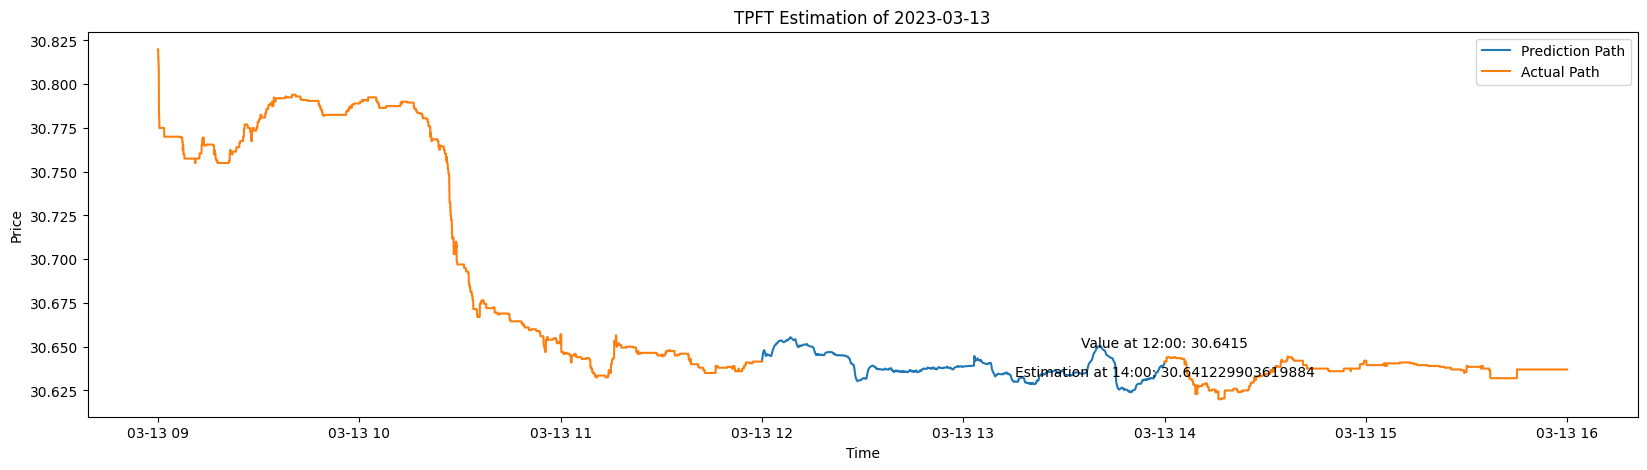

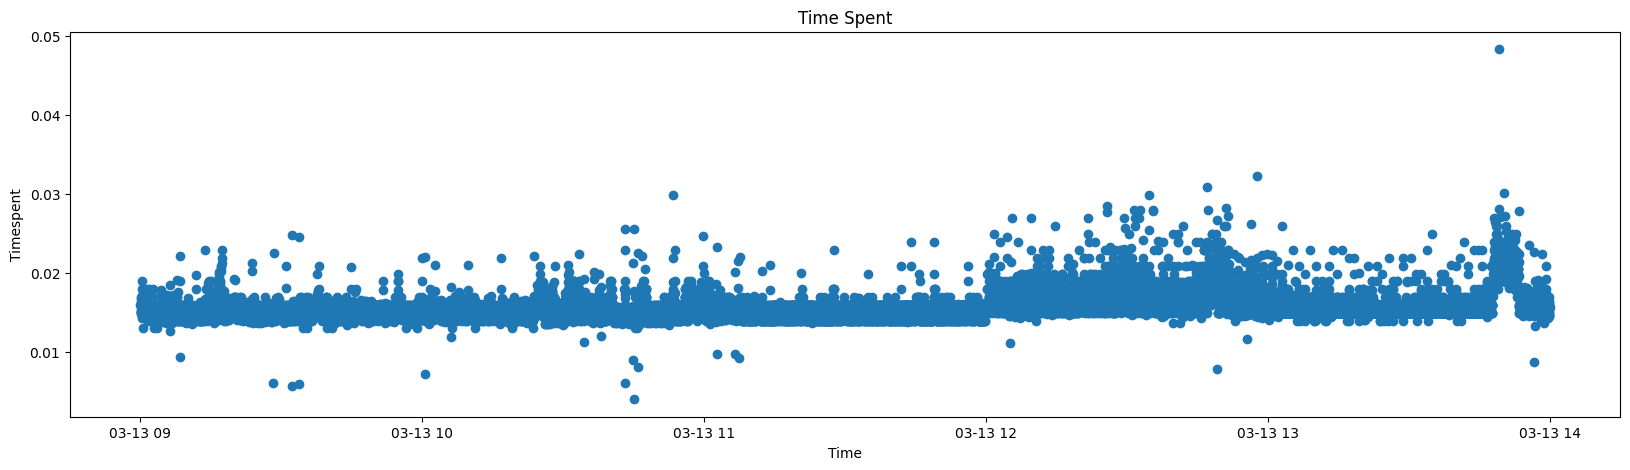

In [7]:
chosen_date = datetime.date(2023, 3, 13)
X_record = np.array([])
y_record = np.array([])
model = LinearRegression()
time_record = []

df = pd.DataFrame({"TPFT": df_TPFT["MID"],  
                "CMPN": df_CMPN["MID"]})

for date_idx in tqdm(df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(14, 0))].index, desc="Processing", unit="rows"):
    start = time.time()
    
    TPFT_new_input = df[df.index == date_idx]["TPFT"].values[0]
    CMPN_new_input = df[df.index == date_idx]["CMPN"].values[0]
    X_record = np.append(X_record, [CMPN_new_input])
    
    if date_idx.time() <= datetime.time(12, 0): # Storing all training sets 
        y_record = np.append(y_record, [TPFT_new_input])
        
    if date_idx.time() == datetime.time(12, 0): # Fit and get Parameters ONLY ONCE! 
        real_closing = TPFT_new_input
        X_record = X_record.reshape(-1, 1)
        model.fit(X_record, y_record)
        y_pred = model.predict(X_record)
        X_record = X_record.reshape(-1)
        index_of_12 = len(X_record) - 1
        
    if (date_idx.time() > datetime.time(12, 0)) & (date_idx.time() <= datetime.time(14, 0)):
        # Fit, Denoise and Shift
        y_pred = np.append(y_pred, model.predict([[CMPN_new_input]])) # Fit


        # Convert the numpy array to pandas Series
        y_pred_series = pd.Series(y_pred)

        # Calculate the Exponential Moving Average
        smoothed_y_pred = y_pred_series.ewm(span=37, adjust=False).mean().values
        
        est_closing = smoothed_y_pred[index_of_12]
        smoothed_y_pred = smoothed_y_pred - (est_closing - real_closing) # Shift
        
    end = time.time()
    time_record.append(end - start)

smoothed_y_pred = pd.DataFrame(smoothed_y_pred, index = df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(14, 0))].index, columns = ['Prediction'])

plt.figure(figsize = (20, 5))
plt.title(f"TPFT Estimation of {chosen_date}")
plt.plot(smoothed_y_pred[(smoothed_y_pred.index.time > datetime.time(12, 0)) & (smoothed_y_pred.index.time <= datetime.time(14, 0))], "-", label = "Prediction Path")
plt.plot(df[( df.index.date == chosen_date)]["TPFT"], "-", label = "Actual Path")
plt.annotate(f'Value at 12:00: {df[( df.index.date == chosen_date) & (df.index.time == datetime.time(14, 0))]["TPFT"].values[0]}', (datetime.datetime.combine(chosen_date, datetime.time(14, 0)), df[( df.index.date == chosen_date) & (df.index.time == datetime.time(14, 0))]["TPFT"].values[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'Estimation at 14:00: {smoothed_y_pred[smoothed_y_pred.index.time == datetime.time(14, 0)].values[0][0]}', (datetime.datetime.combine(chosen_date, datetime.time(14, 0)),smoothed_y_pred[smoothed_y_pred.index.time == datetime.time(14, 0)].values[0][0]), textcoords="offset points", xytext=(0, -10), ha='center')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize = (20, 5))
plt.title("Time Spent")
plt.plot(df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(14, 0))].index, time_record, "o")
plt.xlabel("Time")
plt.ylabel("Timespent")
plt.show()

In [8]:
smoothed_y_pred

,Prediction
Dates,
2023-03-13 09:00:01,30.814092
2023-03-13 09:00:02,30.814092
2023-03-13 09:00:03,30.814619
2023-03-13 09:00:04,30.815453
2023-03-13 09:00:05,30.816243
...,...
2023-03-13 13:59:56,30.640709
2023-03-13 13:59:57,30.640814
2023-03-13 13:59:58,30.640974


# Performance

## Linear Regression + EMA100 + Shifting

In [25]:
def get_pred_path(date, time, model, window):
    y_pred = model.predict(df[(df.index.date == date) & (df.index.time <= time)][["CMPN"]]) # Fit 

    y_pred = pd.DataFrame(y_pred, index = df[(df.index.date == date) & (df.index.time <= time)].index, columns = ["Prediction"])
    y_pred = y_pred.ewm(span=window).mean()
    real_closing = df[(df.index.date == date) & (df.index.time == datetime.time(12, 0))]["TPFT"].values[0]
    est_closing = y_pred[(y_pred.index.date == date) & (y_pred.index.time == datetime.time(12, 0))]["Prediction"].values[0]
    y_pred = y_pred - est_closing + real_closing # Shift
    
    return y_pred

# Variables Setting
model = LinearRegression()
df = pd.DataFrame({
    "TPFT": df_TPFT["MID"], 
    "CMPN": df_CMPN["MID"]
})
accuracy_of_1215 = 0
accuracy_of_1230 = 0
accuracy_of_1245 = 0
accuracy_of_1300 = 0
accuracy_of_1315 = 0
accuracy_of_1330 = 0
accuracy_of_1345 = 0

accuracy_of_1215_their = 0
accuracy_of_1230_their = 0
accuracy_of_1245_their = 0
accuracy_of_1300_their = 0
accuracy_of_1315_their = 0
accuracy_of_1330_their = 0
accuracy_of_1345_their = 0

day_count = 0

window = 37

# Dataset Setting
for chosen_date in tqdm(dates, desc="Processing", unit="rows"): 
    
    day_count += 1

    X_train = df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(12, 0))][["CMPN"]]
    y_train = df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(12, 0))]["TPFT"]

    # Fit
    model.fit(X_train, y_train)

    # Get Prediction Path
    y_pred_1215_path = get_pred_path(chosen_date, datetime.time(12, 15), model, window)
    y_pred_1230_path = get_pred_path(chosen_date, datetime.time(12, 30), model, window)
    y_pred_1245_path = get_pred_path(chosen_date, datetime.time(12, 45), model, window)
    y_pred_1300_path = get_pred_path(chosen_date, datetime.time(13, 00), model, window)
    y_pred_1315_path = get_pred_path(chosen_date, datetime.time(13, 15), model, window)
    y_pred_1330_path = get_pred_path(chosen_date, datetime.time(13, 30), model, window)
    y_pred_1345_path = get_pred_path(chosen_date, datetime.time(13, 45), model, window)

    # Get Prediction Spot
    y_pred_1215 = y_pred_1215_path.loc[y_pred_1215_path.index[-1]].values[0]
    y_pred_1230 = y_pred_1230_path.loc[y_pred_1230_path.index[-1]].values[0]
    y_pred_1245 = y_pred_1245_path.loc[y_pred_1245_path.index[-1]].values[0]
    y_pred_1300 = y_pred_1300_path.loc[y_pred_1300_path.index[-1]].values[0]
    y_pred_1315 = y_pred_1315_path.loc[y_pred_1315_path.index[-1]].values[0]
    y_pred_1330 = y_pred_1330_path.loc[y_pred_1330_path.index[-1]].values[0]
    y_pred_1345 = y_pred_1345_path.loc[y_pred_1345_path.index[-1]].values[0]
    
    # Get Previous Prediction Spot
    y_pred_1215_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(12, 15))]["MID"].values[0]
    y_pred_1230_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(12, 30))]["MID"].values[0]
    y_pred_1245_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(12, 45))]["MID"].values[0]
    y_pred_1300_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 00))]["MID"].values[0]
    y_pred_1315_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 15))]["MID"].values[0]
    y_pred_1330_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 30))]["MID"].values[0]
    y_pred_1345_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 45))]["MID"].values[0]
    
    # Get Prediction Target
    y_at_15 = df[(df.index.date == chosen_date) & (df.index.time == datetime.time(15, 0))]["TPFT"].values[0]

    # Get Accuracies
    accuracy_of_1215 += np.abs(y_at_15 - y_pred_1215)
    accuracy_of_1230 += np.abs(y_at_15 - y_pred_1230)
    accuracy_of_1245 += np.abs(y_at_15 - y_pred_1245)
    accuracy_of_1300 += np.abs(y_at_15 - y_pred_1300)
    accuracy_of_1315 += np.abs(y_at_15 - y_pred_1315)
    accuracy_of_1330 += np.abs(y_at_15 - y_pred_1330)
    accuracy_of_1345 += np.abs(y_at_15 - y_pred_1345)
    
    # Get Previous Accuracies
    accuracy_of_1215_their += np.abs(y_at_15 - y_pred_1215_their)
    accuracy_of_1230_their += np.abs(y_at_15 - y_pred_1230_their)
    accuracy_of_1245_their += np.abs(y_at_15 - y_pred_1245_their)
    accuracy_of_1300_their += np.abs(y_at_15 - y_pred_1300_their)
    accuracy_of_1315_their += np.abs(y_at_15 - y_pred_1315_their)
    accuracy_of_1330_their += np.abs(y_at_15 - y_pred_1330_their)
    accuracy_of_1345_their += np.abs(y_at_15 - y_pred_1345_their)


Acc_table = pd.DataFrame({
    '12:15': [accuracy_of_1215/day_count, accuracy_of_1215_their/day_count],
    '12:30': [accuracy_of_1230/day_count, accuracy_of_1230_their/day_count],
    '12:45': [accuracy_of_1245/day_count, accuracy_of_1245_their/day_count],
    '13:00': [accuracy_of_1300/day_count, accuracy_of_1300_their/day_count],
    '13:15': [accuracy_of_1315/day_count, accuracy_of_1315_their/day_count],
    '13:30': [accuracy_of_1330/day_count, accuracy_of_1330_their/day_count],
    '13:45': [accuracy_of_1345/day_count, accuracy_of_1345_their/day_count]}, index= ["New Accuracy", "Previous Accuracy"])

Acc_table = Acc_table.transpose()
Acc_table.style.apply(colorize, axis=1)

Processing: 100%|██████████| 113/113 [1:05:14<00:00, 34.64s/rows]


,New Accuracy,Previous Accuracy
12:15,0.015843,0.017060
12:30,0.016099,0.017721
12:45,0.015550,0.017410
13:00,0.015319,0.017457
13:15,0.015091,0.017297
13:30,0.015253,0.017819
13:45,0.015351,0.017319


## Linear Regression + Wavelet Signal Denoiser + Shifting

In [26]:
def get_pred_path(date, time, model):
    y_pred = model.predict(df[(df.index.date == date) & (df.index.time <= time)][["CMPN"]]) # Fit 
    y_pred = wavelet_denoise(y_pred, wavelet="db8", level=37) # Denoise
    y_pred = pd.DataFrame(y_pred, index = df[(df.index.date == date) & (df.index.time <= time)].index, columns = ["Prediction"])
    real_closing = df[(df.index.date == date) & (df.index.time == datetime.time(12, 0))]["TPFT"].values[0]
    est_closing = y_pred[(y_pred.index.date == date) & (y_pred.index.time == datetime.time(12, 0))]["Prediction"].values[0]
    y_pred = y_pred - est_closing + real_closing # Shift
    
    return y_pred

# Variables Setting
model = LinearRegression()
df = pd.DataFrame({
    "TPFT": df_TPFT["MID"], 
    "CMPN": df_CMPN["MID"]
})
accuracy_of_1215 = 0
accuracy_of_1230 = 0
accuracy_of_1245 = 0
accuracy_of_1300 = 0
accuracy_of_1315 = 0
accuracy_of_1330 = 0
accuracy_of_1345 = 0

accuracy_of_1215_their = 0
accuracy_of_1230_their = 0
accuracy_of_1245_their = 0
accuracy_of_1300_their = 0
accuracy_of_1315_their = 0
accuracy_of_1330_their = 0
accuracy_of_1345_their = 0

day_count = 0

# Dataset Setting
for chosen_date in tqdm(dates, desc="Processing", unit="rows"): 
    
    day_count += 1

    X_train = df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(12, 0))][["CMPN"]]
    y_train = df[(df.index.date == chosen_date) & (df.index.time <= datetime.time(12, 0))]["TPFT"]

    # Fit
    model.fit(X_train, y_train)

    # Get Prediction Path
    y_pred_1215_path = get_pred_path(chosen_date, datetime.time(12, 15), model)
    y_pred_1230_path = get_pred_path(chosen_date, datetime.time(12, 30), model)
    y_pred_1245_path = get_pred_path(chosen_date, datetime.time(12, 45), model)
    y_pred_1300_path = get_pred_path(chosen_date, datetime.time(13, 00), model)
    y_pred_1315_path = get_pred_path(chosen_date, datetime.time(13, 15), model)
    y_pred_1330_path = get_pred_path(chosen_date, datetime.time(13, 30), model)
    y_pred_1345_path = get_pred_path(chosen_date, datetime.time(13, 45), model)

    # Get Prediction Spot
    y_pred_1215 = y_pred_1215_path.loc[y_pred_1215_path.index[-1]].values[0]
    y_pred_1230 = y_pred_1230_path.loc[y_pred_1230_path.index[-1]].values[0]
    y_pred_1245 = y_pred_1245_path.loc[y_pred_1245_path.index[-1]].values[0]
    y_pred_1300 = y_pred_1300_path.loc[y_pred_1300_path.index[-1]].values[0]
    y_pred_1315 = y_pred_1315_path.loc[y_pred_1315_path.index[-1]].values[0]
    y_pred_1330 = y_pred_1330_path.loc[y_pred_1330_path.index[-1]].values[0]
    y_pred_1345 = y_pred_1345_path.loc[y_pred_1345_path.index[-1]].values[0]
    
    # Get Previous Prediction Spot
    y_pred_1215_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(12, 15))]["MID"].values[0]
    y_pred_1230_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(12, 30))]["MID"].values[0]
    y_pred_1245_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(12, 45))]["MID"].values[0]
    y_pred_1300_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 00))]["MID"].values[0]
    y_pred_1315_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 15))]["MID"].values[0]
    y_pred_1330_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 30))]["MID"].values[0]
    y_pred_1345_their = df_est[(df_est.index.date == chosen_date) & (df_est.index.time == datetime.time(13, 45))]["MID"].values[0]
    
    # Get Prediction Target
    y_at_15 = df[(df.index.date == chosen_date) & (df.index.time == datetime.time(15, 0))]["TPFT"].values[0]

    # Get Accuracies
    accuracy_of_1215 += np.abs(y_at_15 - y_pred_1215)
    accuracy_of_1230 += np.abs(y_at_15 - y_pred_1230)
    accuracy_of_1245 += np.abs(y_at_15 - y_pred_1245)
    accuracy_of_1300 += np.abs(y_at_15 - y_pred_1300)
    accuracy_of_1315 += np.abs(y_at_15 - y_pred_1315)
    accuracy_of_1330 += np.abs(y_at_15 - y_pred_1330)
    accuracy_of_1345 += np.abs(y_at_15 - y_pred_1345)
    
    # Get Previous Accuracies
    accuracy_of_1215_their += np.abs(y_at_15 - y_pred_1215_their)
    accuracy_of_1230_their += np.abs(y_at_15 - y_pred_1230_their)
    accuracy_of_1245_their += np.abs(y_at_15 - y_pred_1245_their)
    accuracy_of_1300_their += np.abs(y_at_15 - y_pred_1300_their)
    accuracy_of_1315_their += np.abs(y_at_15 - y_pred_1315_their)
    accuracy_of_1330_their += np.abs(y_at_15 - y_pred_1330_their)
    accuracy_of_1345_their += np.abs(y_at_15 - y_pred_1345_their)


Acc_table = pd.DataFrame({
    '12:15': [accuracy_of_1215/day_count, accuracy_of_1215_their/day_count],
    '12:30': [accuracy_of_1230/day_count, accuracy_of_1230_their/day_count],
    '12:45': [accuracy_of_1245/day_count, accuracy_of_1245_their/day_count],
    '13:00': [accuracy_of_1300/day_count, accuracy_of_1300_their/day_count],
    '13:15': [accuracy_of_1315/day_count, accuracy_of_1315_their/day_count],
    '13:30': [accuracy_of_1330/day_count, accuracy_of_1330_their/day_count],
    '13:45': [accuracy_of_1345/day_count, accuracy_of_1345_their/day_count]}, index= ["New Accuracy", "Previous Accuracy"])

Acc_table = Acc_table.transpose()
Acc_table.style.apply(colorize, axis=1)

Processing: 100%|██████████| 113/113 [1:00:28<00:00, 32.11s/rows]


,New Accuracy,Previous Accuracy
12:15,0.015709,0.017060
12:30,0.016075,0.017721
12:45,0.015594,0.017410
13:00,0.015313,0.017457
13:15,0.015145,0.017297
13:30,0.015328,0.017819
13:45,0.015456,0.017319
